<div class="alert alert-block alert-info">
<ul><strong>
<li>Justin Chin | Miguel Dominguez</li>
<li>CSC 59929</li>
<li>Machine Learning</li>
<li>Dr. Erik K. Grimmelmann</li>
<li>Date: </li>
<li>Project</li>
</strong>
</ul>
</div>

In [1]:
import os
import numpy as np
import pandas as pd
import math
%matplotlib inline
from matplotlib.ticker import MaxNLocator 
import matplotlib as mpl
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
inline_rc = dict(mpl.rcParams)
from IPython.display import Image
import timeit
import time
from astropy.table import Table, Column
import graphviz 
from graphviz import Digraph

<img src="bones.jpg">

# About the dataset

In [2]:
#Get Bird Bone Dataframe
birds = pd.read_csv('bird.csv', sep=',')
new_columns = ['ID', 'Humerus L', 'Humerus D', 'Ulna L','Ulna D', 'Femur L', 'Femur D',
              'Tibiotarsus L', 'Tibiotarsus D', 'Tarsometatarsus L','Tarsometatarsus D', 'Type'] 
birds.columns = new_columns

print("Raw: " ,birds.shape)

#Drop rows with NaN values
birds = birds.dropna()

print("Cleaned: ",birds.shape)

birds.head()

Raw:  (420, 12)
Cleaned:  (413, 12)


ID  Humerus L  Humerus D  Ulna L  Ulna D  Femur L  Femur D  Tibiotarsus L  \
0   0      80.78       6.68   72.01    4.88    41.81     3.70           5.50   
1   1      88.91       6.63   80.53    5.59    47.04     4.30          80.22   
2   2      79.97       6.37   69.26    5.28    43.07     3.90          75.35   
3   3      77.65       5.70   65.76    4.77    40.04     3.52          69.17   
4   4      62.80       4.84   52.09    3.73    33.95     2.72          56.27   

   Tibiotarsus D  Tarsometatarsus L  Tarsometatarsus D Type  
0           4.03              38.70               3.84   SW  
1           4.51              41.50               4.01   SW  
2           4.04              38.31               3.34   SW  
3           3.40              35.78               3.41   SW  
4           2.96              31.88               3.13   SW

In [3]:
#Get data X and class Y
X = birds.iloc[:,1:11].values
y = birds['Type'].values

#Transform Type values for birds into numerical classes ranging from 0 to 5
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y)
#y # 3,5,4,1,0,2 === > SW, W, T, R, P, SO

In [4]:
#Build a dictionary with the feature names.
label = [ 'Humerus L', 'Humerus D', 'Ulna L','Ulna D', 'Femur L', 'Femur D',
              'Tibiotarsus L', 'Tibiotarsus D', 'Tarsometatarsus L','Tarsometatarsus D']
feature_dict = {i:label for i,label in zip(range(0,11), new_columns)}

#Labels for Classes
label_dict = {3: 'SW', 5: 'W', 4: 'T', 1: 'R', 0: 'P', 2: 'SO'}

# Functions

In [5]:
def plot_decision_regions(X, y, classifier,
    test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('^', 's', 'o','^', 's', 'o')
    #colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    colors = colorsBirds
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
    np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,20))
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    # plot all samples
    X_test, y_test = X[test_idx, :], y[test_idx]
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

In [6]:
def make_meshgrid(x, y, h=.01):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, color = col, alpha=0.8)
    return out

def autolabel(rects,fontsize=20):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1*height, int(height), ha='center', va='bottom',fontsize=fontsize)
            
def barchart(model_accuracy, model_title,optext):
    """Plot bars for accuracy for each model.
    
    Parameters
    ----------
    model_accuracy: list of float accuracy values
    model_title: list of names for each model
    optext: optional string that is part of plot graph
    """
    width = 0.75
    ind = np.arange(10)
    fig, ax = plt.subplots(figsize=(20,15))
    colors = ['#DEB887','#A1EAFB','#CFEE91','#FFFF99','#49BEB7','#F0DC82','#FF69B4','#D22D1E','#C000C5','g']
    bars = ax.bar([0,1,2,3,4,5,6,7,8,9], model_accuracy , width, color=colors)

    #Add some text for labels, title and axes ticks
    ax.set_xlabel("Models",fontsize=20)
    ax.set_ylabel('Accuracy',fontsize=20)
    ax.set_title('SVM Kernels Models and their Accuracy' + optext,fontsize=35)
    ax.set_xticks(ind) #Positioning on the x axis
    ax.set_xticklabels(range(0,10),
                      fontsize = 20)
    ax.legend(bars,model_title, loc= 'upper center',fontsize=25)
    autolabel(bars)
    plt.ylim([0,2])
    plt.show()

In [7]:
colorsBirds = ('#911eb4','#f58231','#ffe119','#3cb44b','#e6194b','#008080')

# Statistics

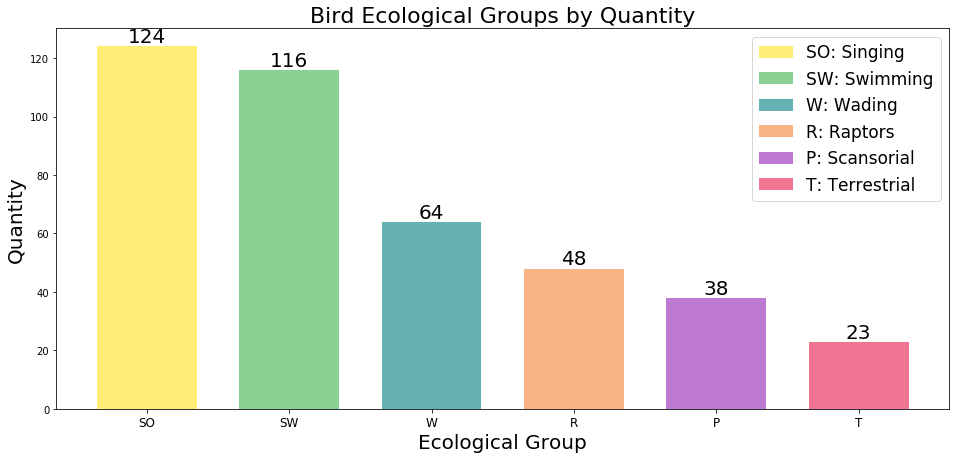

In [8]:
#Obtain value counts for Type column of the DataFrame
all_birds = birds['Type'].value_counts()
val_birds = all_birds.values.tolist() #Numerical value counts for classes
lab_birds = all_birds.axes[0].tolist() #Labels

#Histogram variables
width = 0.7 
ind = np.arange(6)  # the x locations for the groups
fig, ax = plt.subplots(figsize=(16,7))
bird_bars = ax.bar(ind, val_birds , width, color=['#ffe119','#3cb44b','#008080','#f58231','#911eb4','#e6194b'],alpha=0.6)

#Add text for labels, title and axes ticks
ax.set_xlabel("Ecological Group",fontsize=20)
ax.set_ylabel('Quantity',fontsize=20)
ax.set_title('Bird Ecological Groups by Quantity',fontsize=22)
ax.set_xticks(ind) #Positioning on the x axis
ax.set_xticklabels(['SO', 'SW', 'W', 'R', 'P', 'T'], fontsize = 12)
ax.legend(bird_bars, ['SO: Singing','SW: Swimming', 'W: Wading','R: Raptors','P: Scansorial', 'T: Terrestrial'], fontsize=17)
autolabel(bird_bars)
plt.show()  

# Correlation Matrix

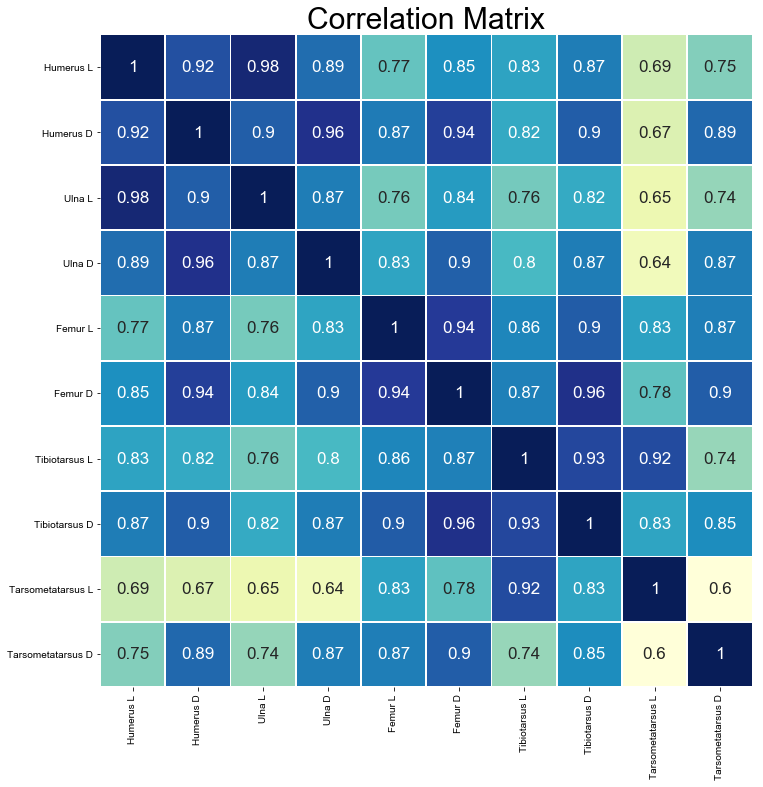

In [9]:
import seaborn as sns

#Get correlation coefficients for each pair of features
correlations = birds[label].corr()

#Size of correlation heatmap
fig, ax = plt.subplots(figsize=(12, 12))

sns.set(font_scale = 2)

#Plot map using correlation
sns.heatmap(correlations, cmap="YlGnBu",square=True, ax=ax,  cbar=False, 
    annot=True, annot_kws={"fontsize": 17}, linewidths= 0.7,
    cbar_kws={"orientation": "horizontal"})


fig = ax.set_title("Correlation Matrix", fontsize=30)
plt.show()

# Correlation Graphs

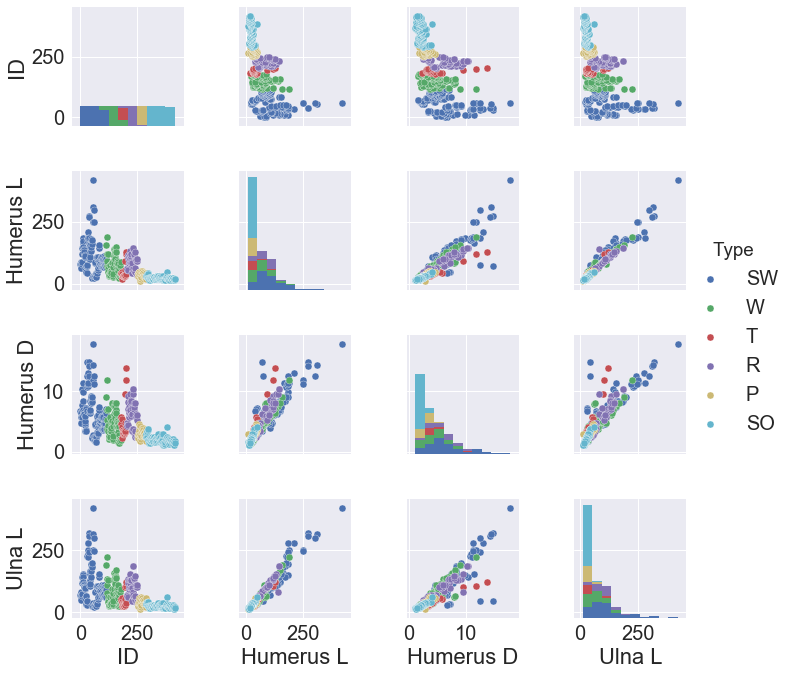

In [10]:
dfplot = birds.drop(new_columns[4:11],1) # Show first 4 pairs
plt.close() #clear old plots
sns.pairplot(dfplot,hue="Type",size=2.5) # plot these
plt.show() #show new plot
plt.close()

# Feature Distribution

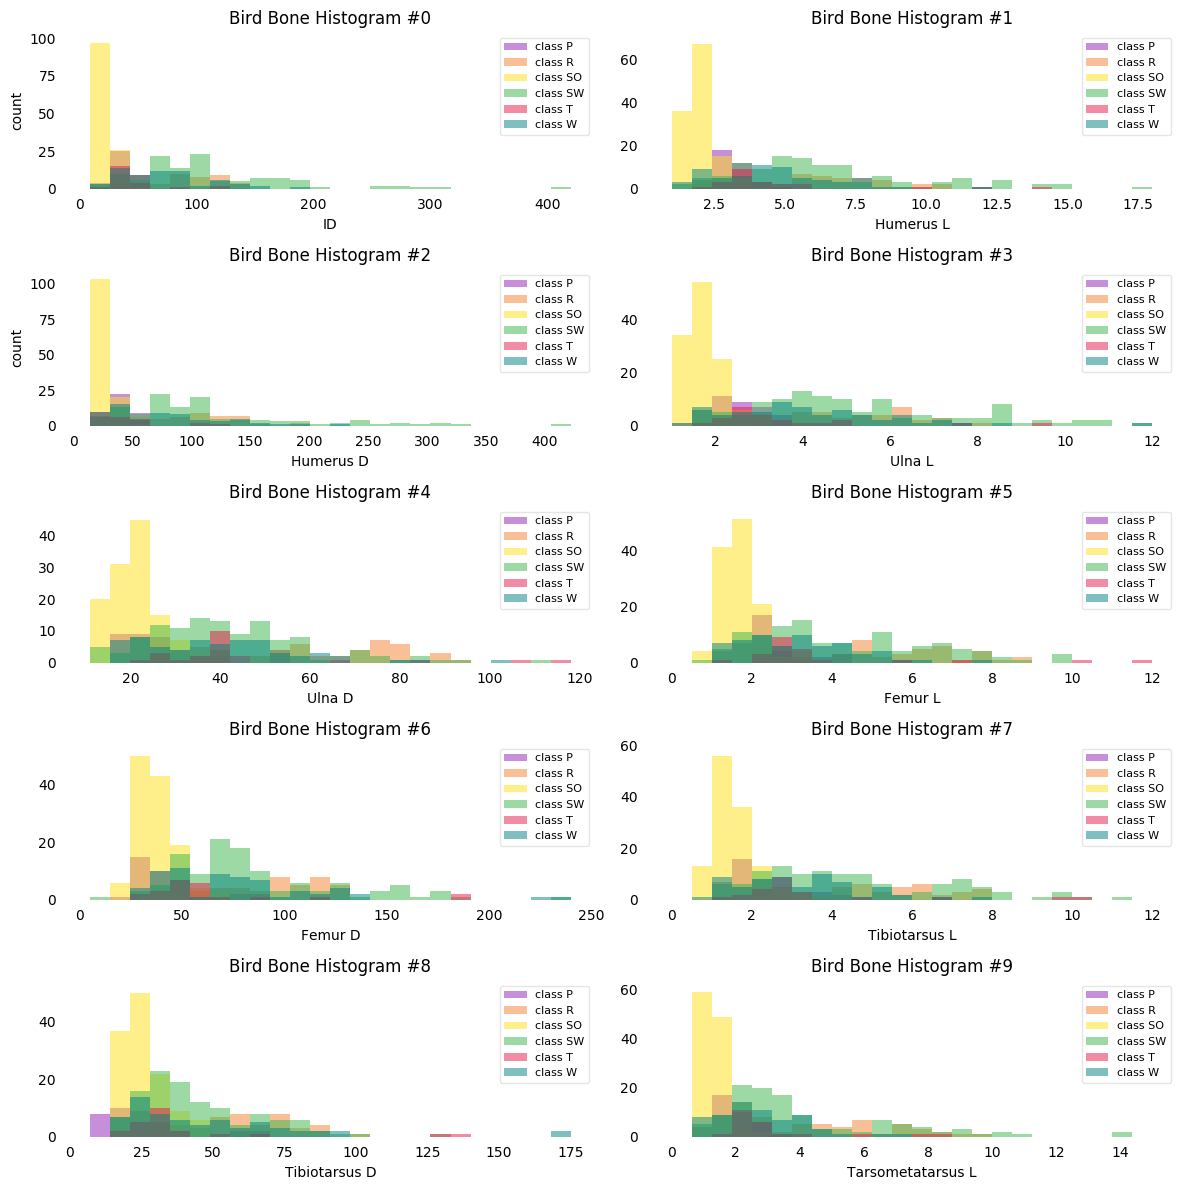

In [11]:
mpl.rcParams.update(mpl.rcParamsDefault)
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,12))

for ax,cnt in zip(axes.ravel(), range(0,11)):  
    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)
    

    # plottling the histograms
    for lab,col in zip(range(0,6), colorsBirds ):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Bird Bone Histogram #%s' %str(cnt))
    
    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")
    
    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')
fig.tight_layout()       
plt.show()

# Pre-processing techniques:

# Data Reduction 

In [12]:
def plot_dimension_reduction(X, title,ax_label):
    """Plot the 2D reduced subspace of data X.

    Parameters
    ----------
    X: reduced data subspace of 2 dimensions
    title: title for graph
    ax_title: x and y axes label name
    """
    #Set plot 
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
    
    #Set markers and colors for each sample point and scatter them.
    for label,marker,color in zip(
        range(0,6),('^', 's', 'o','^', 's', 'o'), colorsBirds):

        plt.scatter(x=X[:,0][y == label],
                    y=X[:,1][y == label], # flip the figure
                    marker=marker,
                    color=color,
                    alpha=0.5,
                    label=label_dict[label])
    #Set axes labels
    plt.xlabel(ax_label + '1')
    plt.ylabel(ax_label + '2')
    #Set legend
    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title(title,fontsize=20) #title

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.show()

In [13]:
def plot_dimension_reduction_3D(X, title,ax_label):
    """Plot the 3D reduced subspace of data X.

    Parameters
    ----------
    X: reduced data subspace of 3 dimensions
    title: title for graph
    ax_title: x,y and z axes label name
    """
    #Set plot
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d') #For 3D graph
    
    #Set markers and colors for each sample point and scatter them.
    for label,marker,color in zip(range(0,6),('^', 's', 'o','^', 's', 'o'), colorsBirds):
        ax.scatter(X[:,0][y == label], X[:,1][y == label],  X[:,2][y == label],
                    marker=marker, color=color, alpha=0.6, label=label_dict[label])
    #Labels for axes and title 
    ax.set_xlabel(ax_label+'1',fontsize=20)
    ax.set_ylabel(ax_label+'2',fontsize=20)
    ax.set_zlabel(ax_label+'3',fontsize=20)
    plt.title(title,fontsize=25)
    ax.view_init(azim=45) #Rotation: 45 deg is good  
    plt.show()

# Linear Discriminant Analysis (LDA)

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

#LDA reduction to 2 and 3 dimensions
sklearn_lda = LDA(n_components=2)
Xlda = sklearn_lda.fit_transform(X, y)
sklearn_lda = LDA(n_components=3)
Xlda_3D = sklearn_lda.fit_transform(X, y)

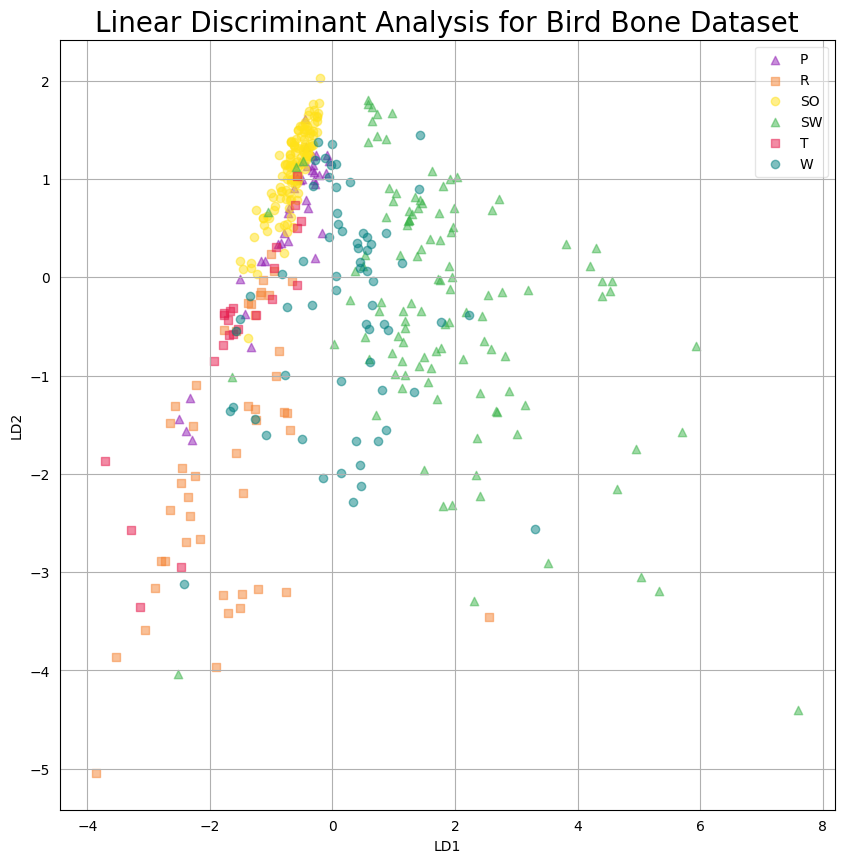

In [15]:
plot_dimension_reduction(Xlda,'Linear Discriminant Analysis for Bird Bone Dataset','LD')

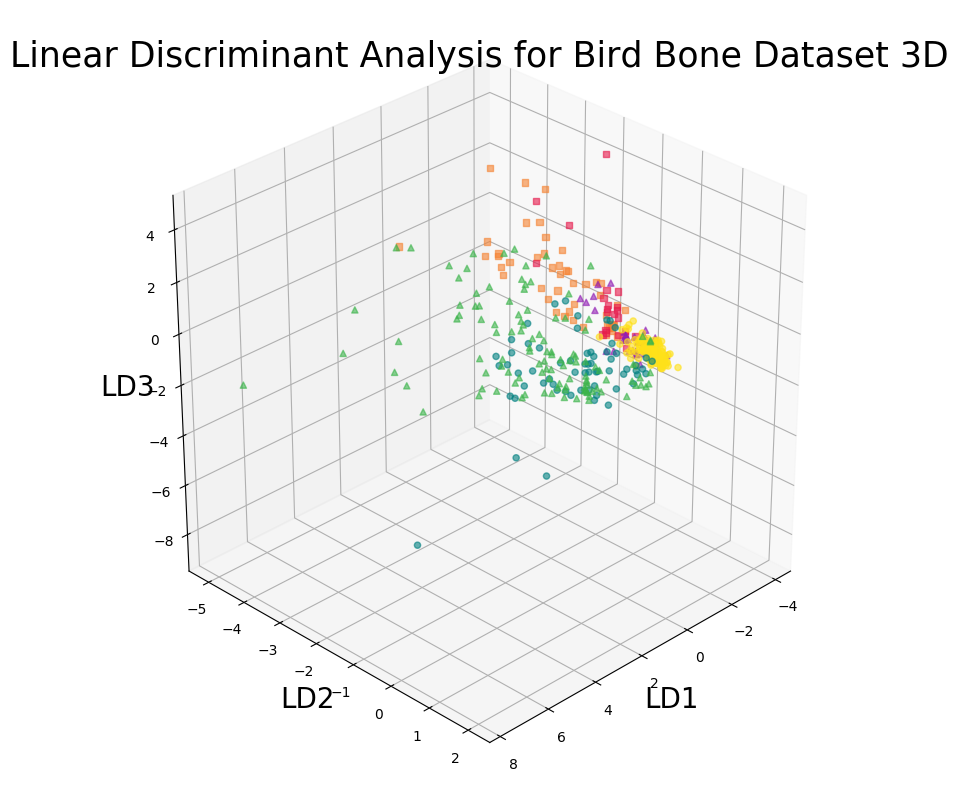

In [16]:
plot_dimension_reduction_3D(Xlda_3D,'Linear Discriminant Analysis for Bird Bone Dataset 3D','LD')

# Principal Component Analysis (PCA)

In [17]:
from sklearn.decomposition import PCA as sklearnPCA

#PCA reduction to 2 and 3 dimensions
sklearn_pca = sklearnPCA(n_components=2)
Xpca = sklearn_pca.fit_transform(X,y)
sklearn_pca = sklearnPCA(n_components=3)
Xpca_3D = sklearn_pca.fit_transform(X,y)

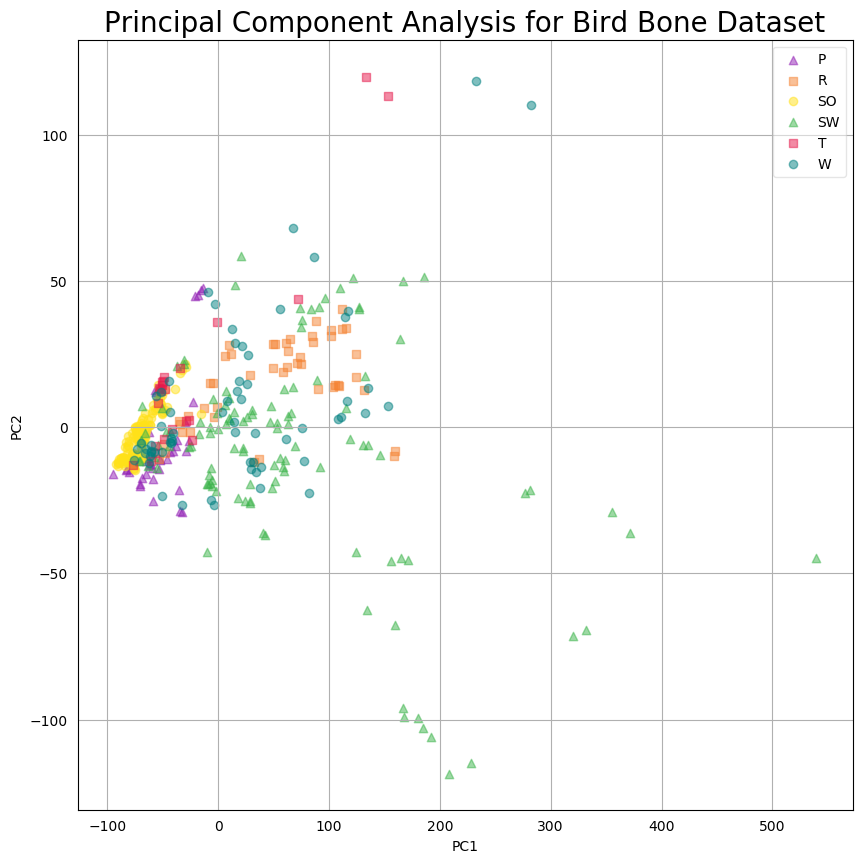

In [18]:
plot_dimension_reduction(Xpca,'Principal Component Analysis for Bird Bone Dataset','PC')

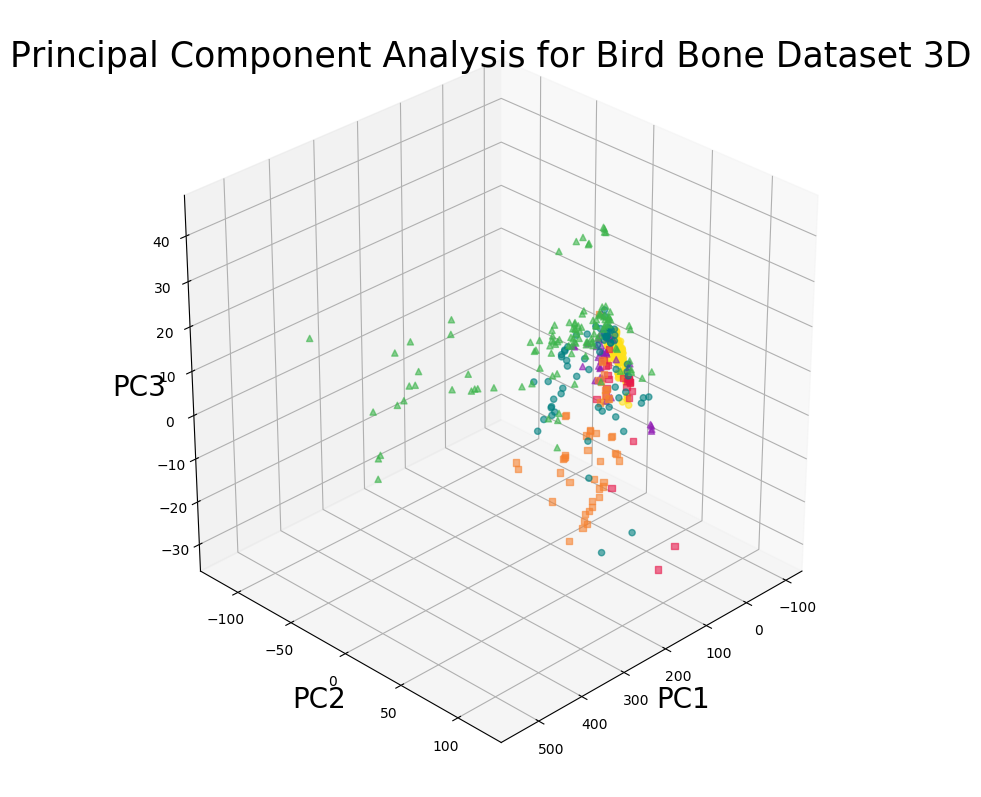

In [19]:
plot_dimension_reduction_3D(Xpca_3D,'Principal Component Analysis for Bird Bone Dataset 3D','PC')

# Isomap

In [20]:
from sklearn.manifold import Isomap as sklearnIsomap

#Isomap reduction to 2 and 3 dimensions
sklearn_iso = sklearnIsomap(n_components=2)
Xiso = sklearn_iso.fit_transform(X,y)
sklearn_iso = sklearnIsomap(n_components=3)
Xiso_3D = sklearn_iso.fit_transform(X,y)

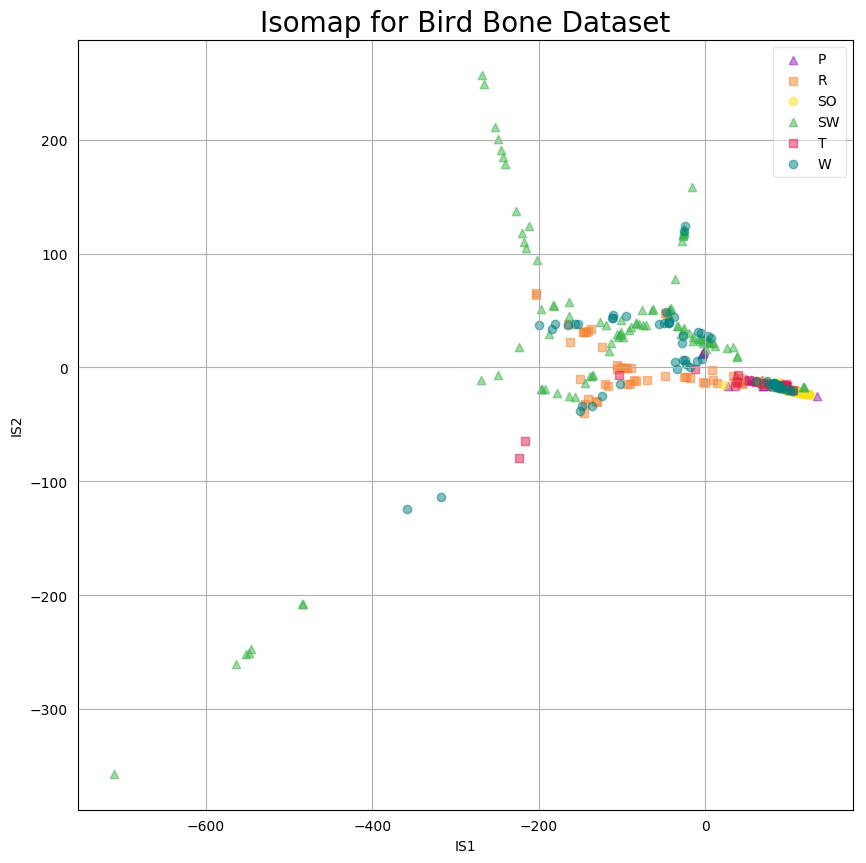

In [21]:
plot_dimension_reduction(Xiso,'Isomap for Bird Bone Dataset','IS')

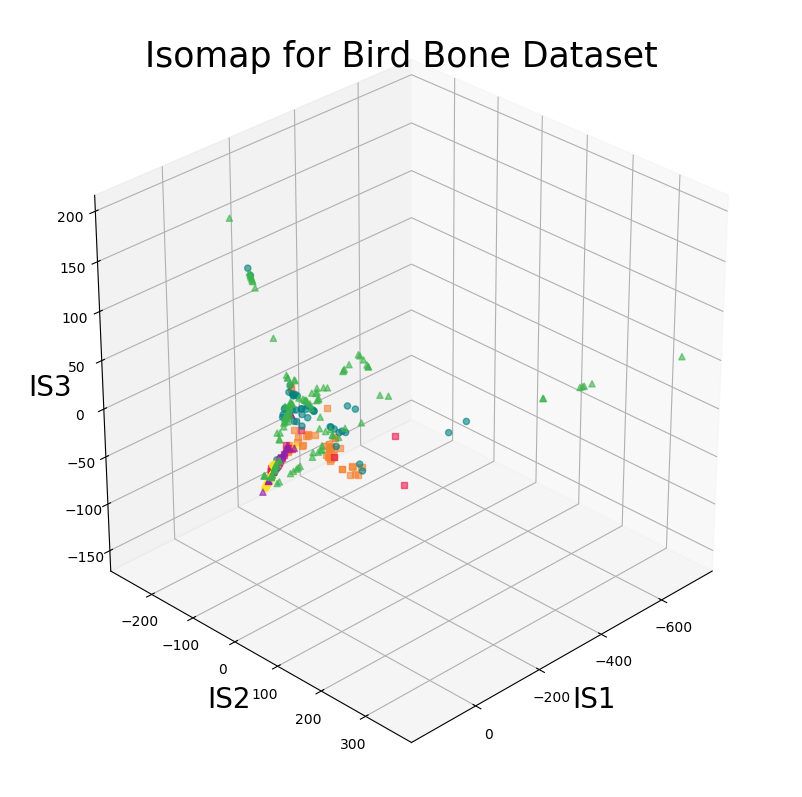

In [22]:
plot_dimension_reduction_3D(Xiso_3D,'Isomap for Bird Bone Dataset','IS')

# Locally Linear Embedding (LLE)

In [23]:
from sklearn.manifold import LocallyLinearEmbedding as sklearnLLE

#LLE reduction to 2 and 3 dimensions
sklearn_lle = sklearnLLE(n_neighbors=15,n_components=2) #15 neighbors is good
Xlle = sklearn_lle.fit_transform(X,y)
sklearn_lle = sklearnLLE(n_neighbors=15,n_components=3)
Xlle_3D = sklearn_lle.fit_transform(X,y)

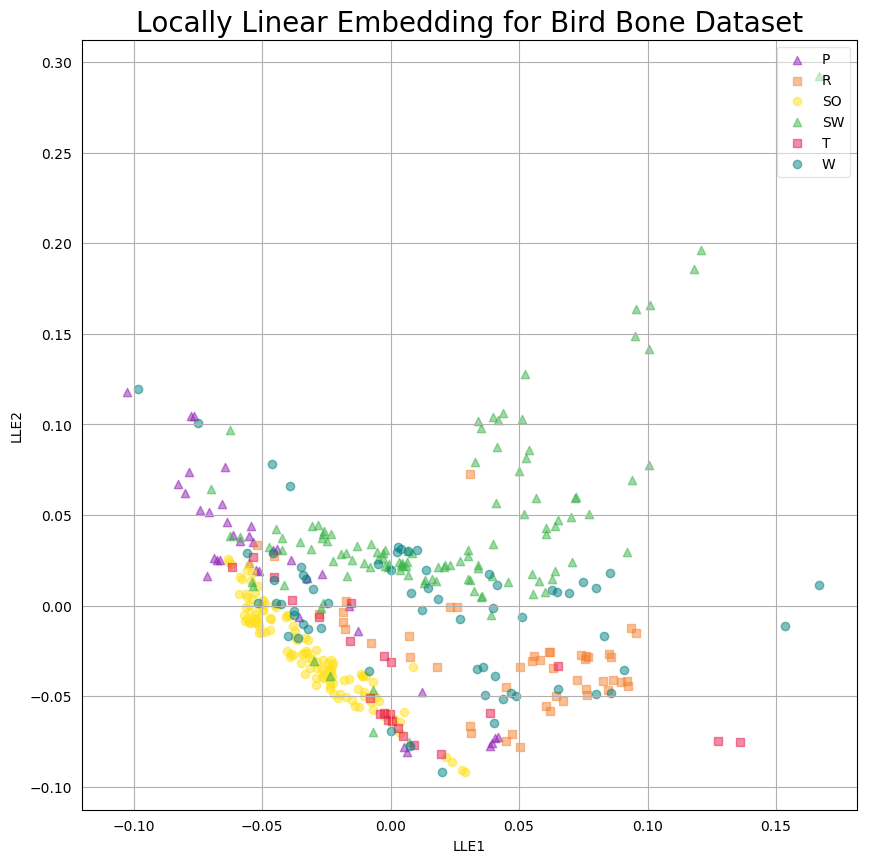

In [24]:
plot_dimension_reduction(Xlle,'Locally Linear Embedding for Bird Bone Dataset','LLE')

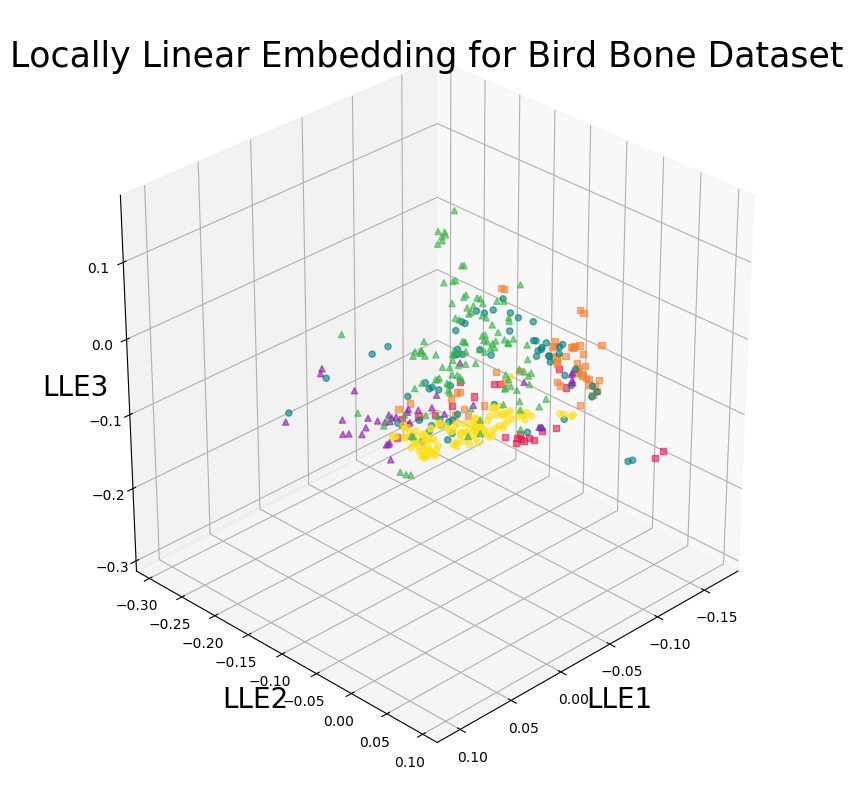

In [25]:
plot_dimension_reduction_3D(Xlle_3D,'Locally Linear Embedding for Bird Bone Dataset','LLE')

# Data Transformation

# Split and Standardize Data

In [26]:
# Split data into 70% training and 30% test data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=3) #Raw split to keep
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X, y, test_size=0.30, random_state=3) #To be normalized

In [27]:
#Standardize the features for both training and testing sets but separately 
for i in range(0,10):
    X_train_std[:,i] = (X_train_std[:,i] - X_train_std[:,i].mean()) / X_train_std[:,i].std() 
for i in range(0,10):
    X_test_std[:,i] = (X_test_std[:,i] - X_test_std[:,i].mean()) / X_test_std[:,i].std() 

In [28]:
label = [ 'Humerus L', 'Humerus D', 'Ulna L','Ulna D', 'Femur L', 'Femur D',
              'Tibiotarsus L', 'Tibiotarsus D', 'Tarsometatarsus L','Tarsometatarsus D']

# Models:

# Perceptron

In [29]:
'''Perceptron'''
from sklearn.linear_model import Perceptron

#table
tlmP = Table(names=('id','Penalty','Alpha','time','score'))

p = ['l1','l2']
reg = [.001,.1,1,10]

for i in range(0,len(p)):
    for k in range(0,len(reg)):
        #Model
        lmP= Perceptron(penalty=p[i],alpha=reg[k])
        #Fit
        startTime = time.time() #start time
        lmP.fit(X_train,y_train)
        endTime = time.time() #end time
        elaspedTime = round(endTime-startTime,4)

        #Add to row
        tlmP.add_row([i+1+(k/10),i+1,reg[k],elaspedTime,round(lmP.score(X_test,y_test),4)])

print("Perceptron")
tlmP.pprint(max_width=-1)

Perceptron
 id Penalty Alpha  time score 
--- ------- ----- ----- ------
1.0     1.0 0.001 0.002  0.379
1.1     1.0   0.1 0.003  0.379
1.2     1.0   1.0 0.003 0.2984
1.3     1.0  10.0 0.001 0.2903
2.0     2.0 0.001 0.001  0.621
2.1     2.0   0.1 0.002 0.2984
2.2     2.0   1.0 0.001 0.1129
2.3     2.0  10.0 0.002 0.1129


C:\Users\migue\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.perceptron.Perceptron'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


# Logistic Regression

In [30]:
'''LogisticRegression'''
from sklearn.linear_model import LogisticRegression

#table
tLR = Table(names=('id','Penalty','C','time','score'))

p = ['l1','l2']
reg = [.001,.1,1,10]

for i in range(0,len(p)):
    for k in range(0,len(reg)):
        #Model
        lr= LogisticRegression(penalty=p[i],C=reg[k])
        #Fit
        startTime = time.time() #start time
        lr.fit(X_train,y_train)
        endTime = time.time() #end time
        elaspedTime = round(endTime-startTime,4)

        #Add to row
        tLR.add_row([i+1+(k/10),i+1,reg[k],elaspedTime,round(lr.score(X_test,y_test),4)])

print("LR")
tLR.pprint(max_width=-1)

LR
 id Penalty   C    time  score 
--- ------- ----- ------ ------
1.0     1.0 0.001  0.004 0.2903
1.1     1.0   0.1 0.0391 0.7581
1.2     1.0   1.0 0.1183 0.8387
1.3     1.0  10.0 0.2263  0.871
2.0     2.0 0.001    0.0  0.621
2.1     2.0   0.1    0.0 0.8065
2.2     2.0   1.0 0.0198 0.8387
2.3     2.0  10.0  0.009 0.8548


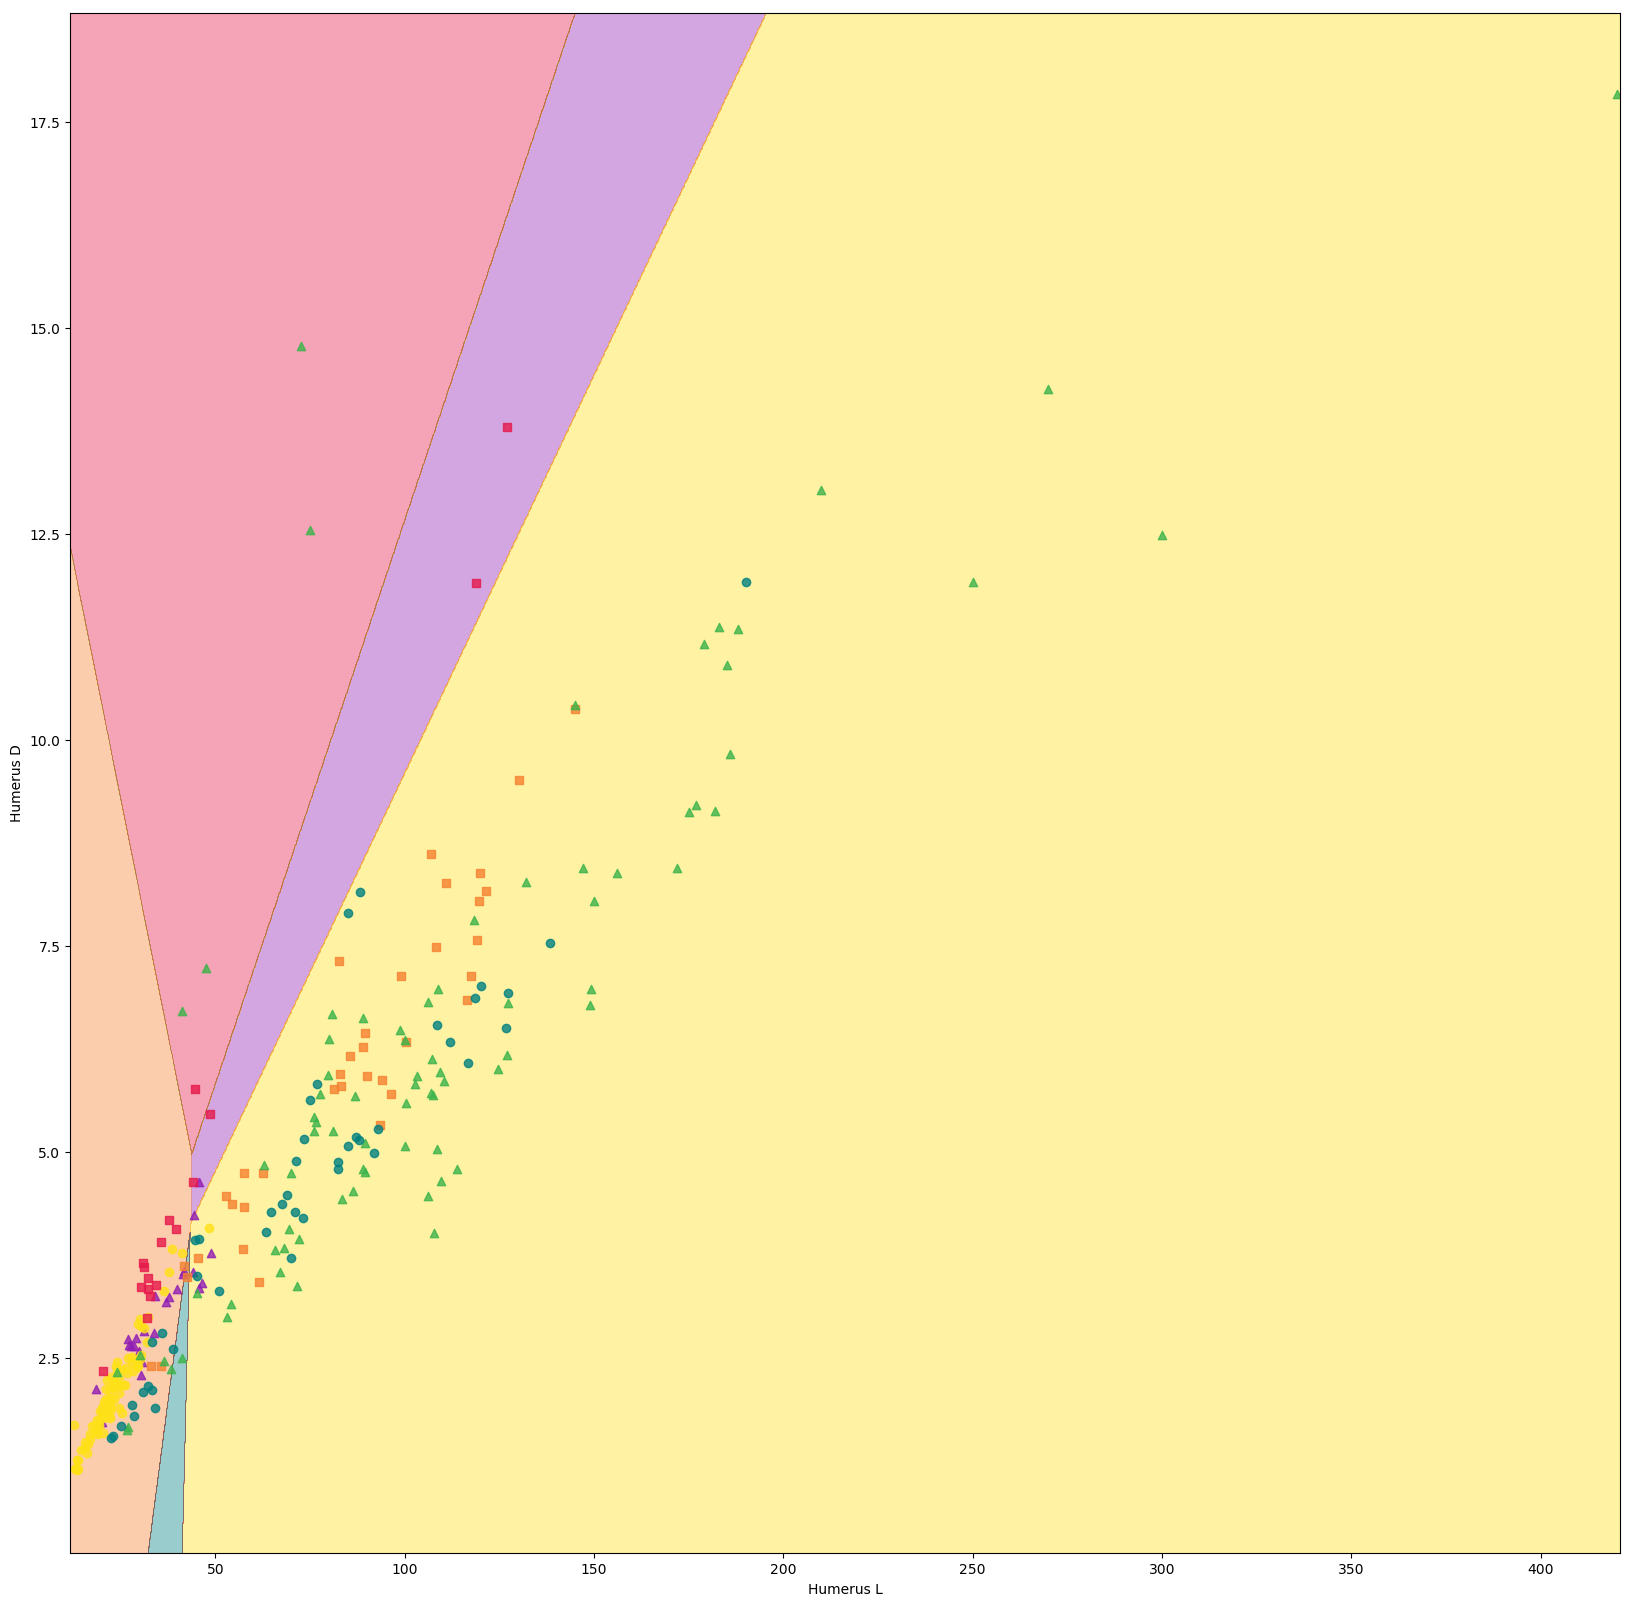

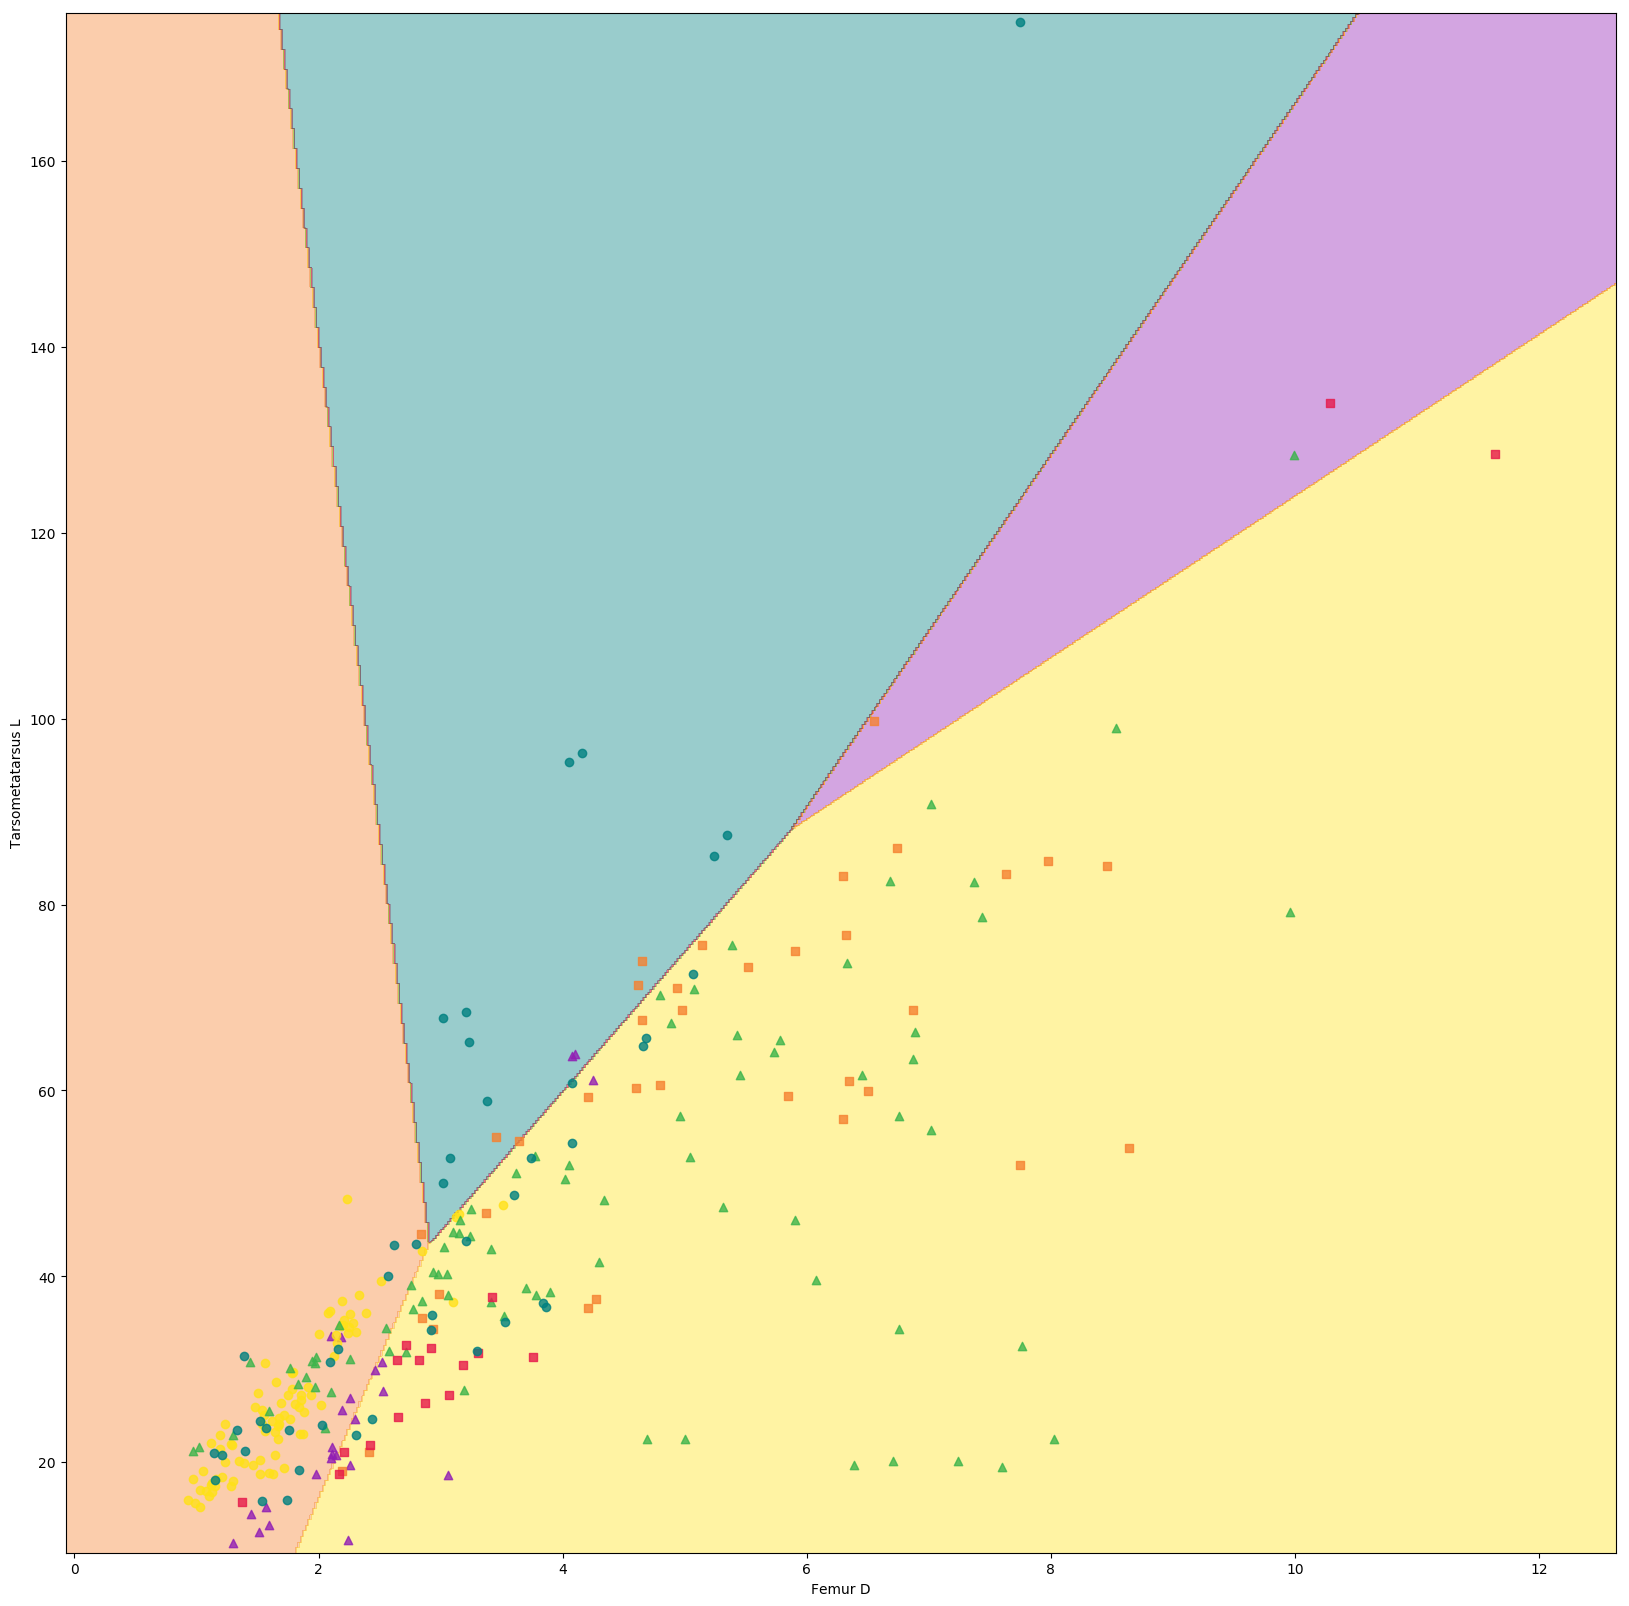

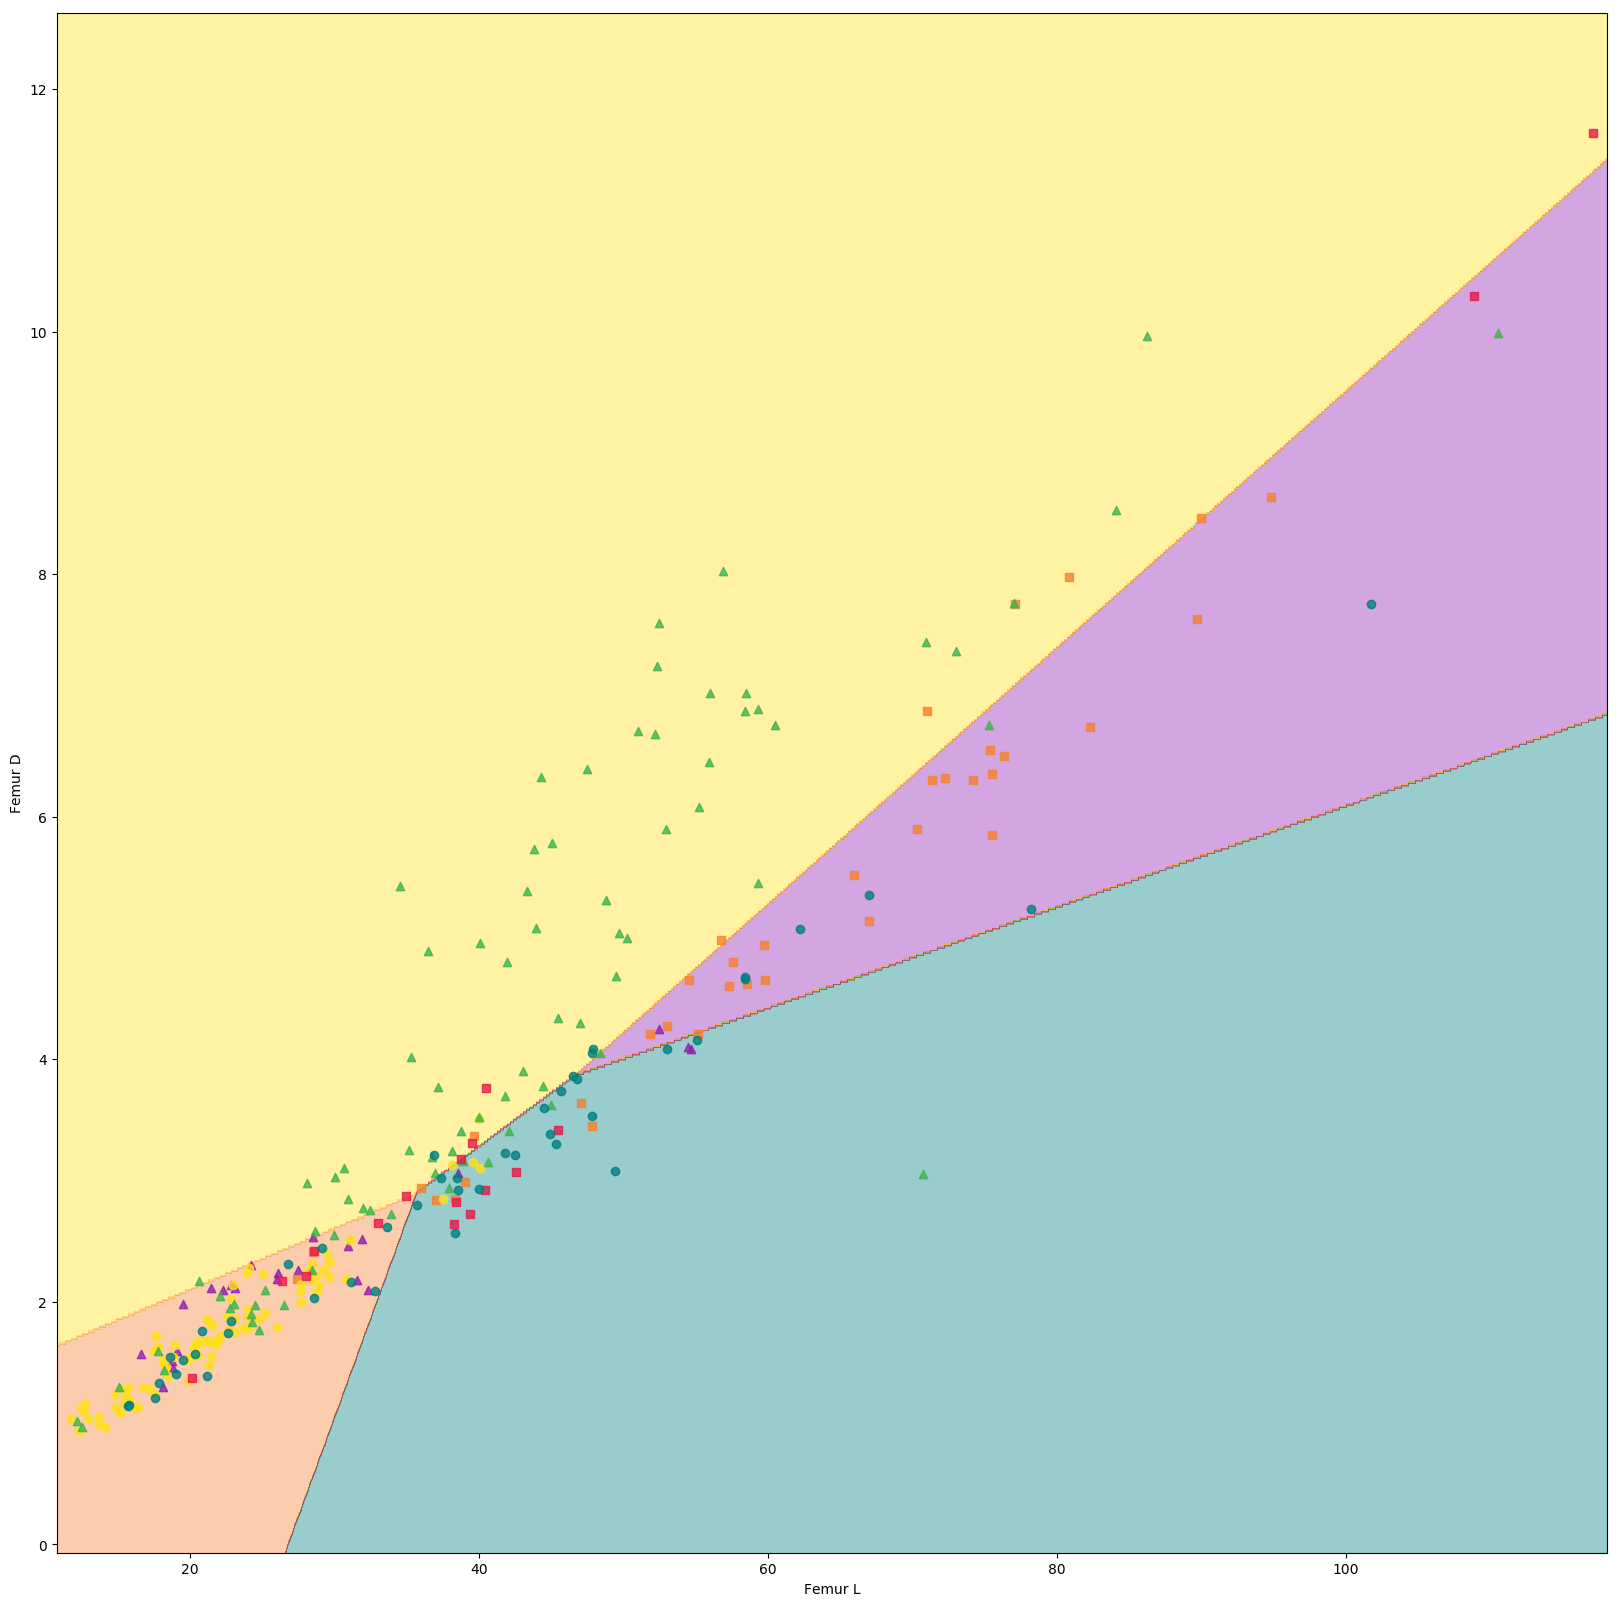

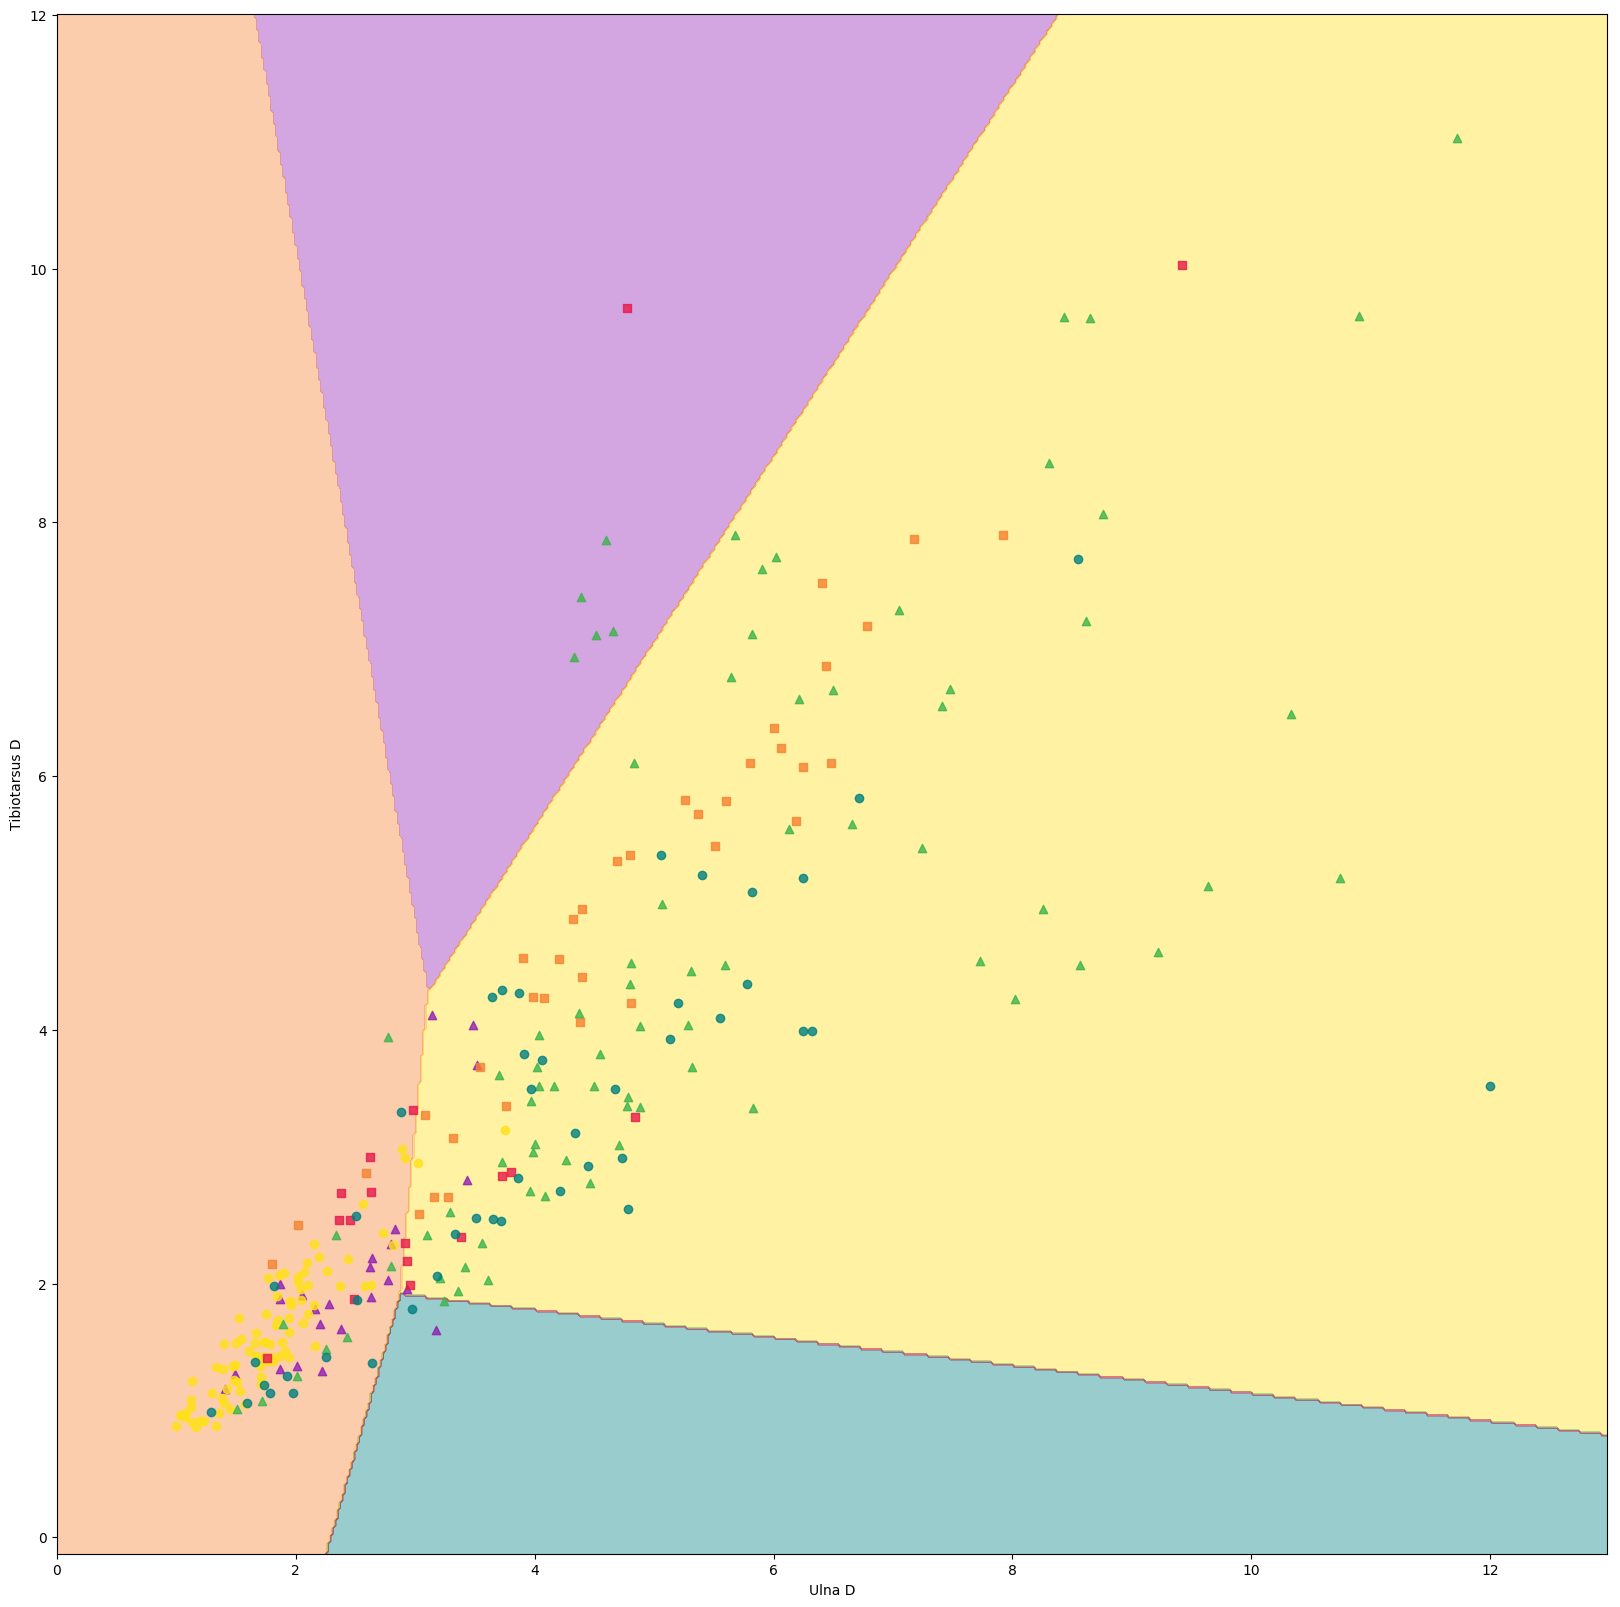

In [31]:
pairs = [(0,1),(5,8),(4,5),(3,7)]
titles = []
for pair in pairs:
    titles.append(label[pair[0]] + " vs " + label[pair[1]])

#Grid of 2x2 for feature pairs
Logi_accuracy = [] #Used to save accuracy

for pair in pairs:
    #Create model for two features first
    Logimodel = LogisticRegression()
    #Train the model
    Logimodel.fit(X_train[:,pair], y_train)
    #Save accuracy for model 
    Logi_accuracy.append(np.around(Logimodel.score(X_test[:,pair], y_test), decimals = 4))
    
    #Plot decision boundaries for that pair 
    plot_decision_regions(X=X_train[:,pair],y=y_train, classifier=Logimodel)
    
    #lables for axes
    plt.xlabel(label[pair[0]])
    plt.ylabel(label[pair[1]])
    
plt.show()

# SVM

In [32]:
from sklearn import svm

In [33]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def barchart(model_accuracy, model_title,optext):
    """Plot bars for accuracy for each model.
    
    Parameters
    ----------
    model_accuracy: list of float accuracy values
    model_title: list of names for each model
    optext: optional string that is part of plot graph
    """
    width = 0.75
    ind = np.arange(6)
    fig, ax = plt.subplots(figsize=(12,10))
    colors = ['#DEB887','#A1EAFB','#CFEE91','#FFFF99','#49BEB7','#F0DC82','#FF69B4','#D22D1E','#C000C5','g']
    bars = ax.bar([0,1,2,3,4,5], model_accuracy , width, color=colors)

    #Add some text for labels, title and axes ticks
    ax.set_xlabel("Models",fontsize=20)
    ax.set_ylabel('Accuracy',fontsize=20)
    ax.set_title('SVM Kernels Models Accuracy' + optext,fontsize=35)
    ax.set_xticks(ind) #Positioning on the x axis
    ax.set_xticklabels(range(0,10),
                      fontsize = 20)
    ax.legend(bars,model_title, loc= 'upper center',fontsize=25)

    def autolabel(rects,fontsize=20):
        """
        Attach a text label above each bar displaying its height
        """
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1*height,height,
                    ha='center', va='bottom',fontsize=fontsize)
    autolabel(bars)
    plt.ylim([0,2])
    plt.show()

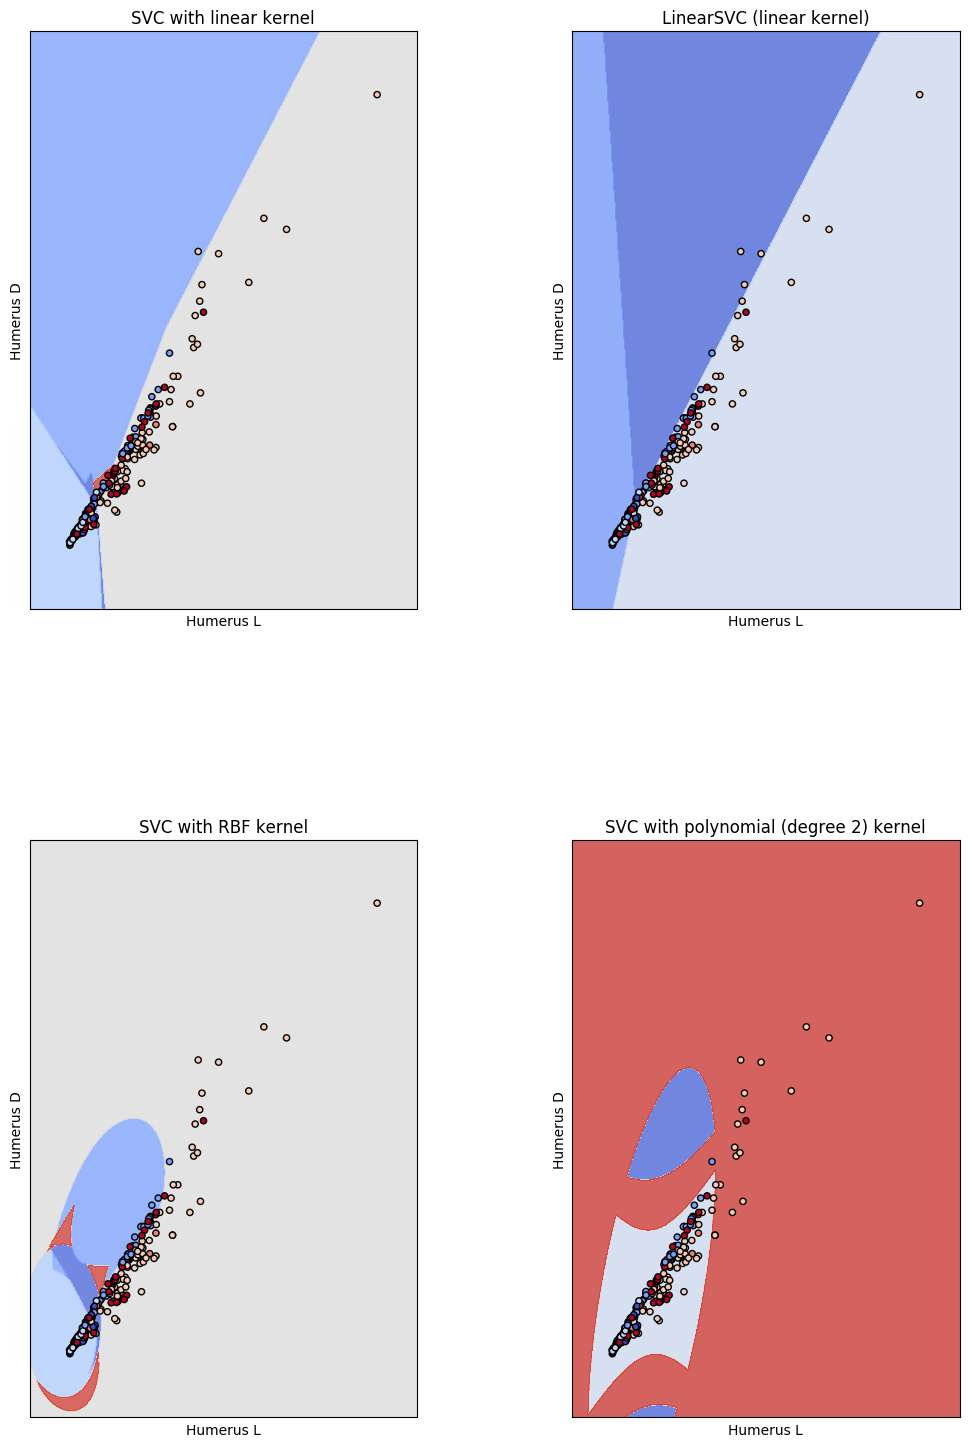

In [34]:
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=2, C=C),
          svm.SVC(kernel='poly', degree=3, C=C),
          svm.SVC(kernel='poly', degree=5, C=C))  #
models = (clf.fit(X_train_std[:,(0,2)], y_train_std) for clf in models)

    
# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 2) kernel',
          'SVC with polynomial (degree 3) kernel',
          'SVC with polynomial (degree 4) kernel') 
    

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(nrows=2, ncols=2, figsize= (12,18))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X_train_std[:,(0)],X_train_std[:,(2)]
xx, yy = make_meshgrid(X0, X1)

accuracy = []

for clf, title, ax in zip(models, titles, sub.flatten()):
    #accuracy.append(np.around(clf.score(X,y),decimals =4))
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, 
                  alpha=0.8)
    ax.scatter(X0, X1, c=y_train,
               cmap=plt.cm.coolwarm, 
               s=20,  edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()


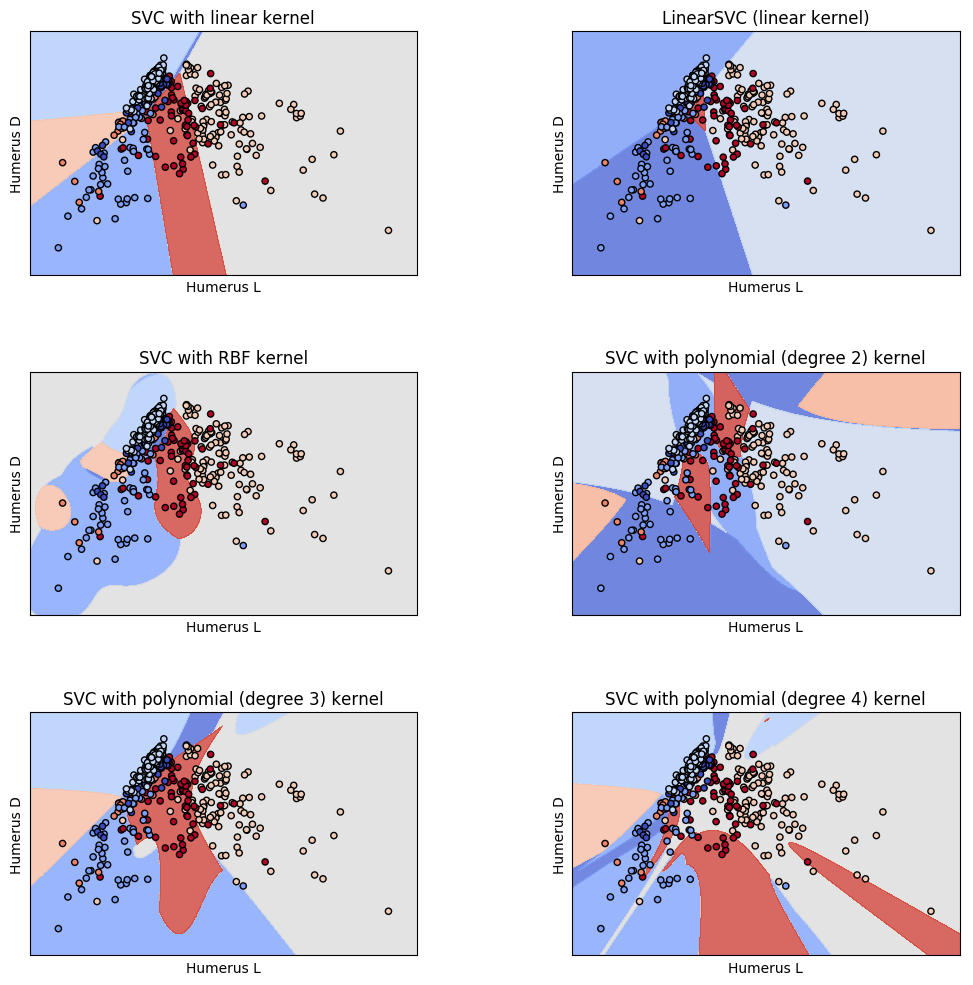

In [35]:
# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=2, C=C),
          svm.SVC(kernel='poly', degree=3, C=C),
          svm.SVC(kernel='poly', degree=5, C=C))  #
models = (clf.fit(Xlda, y) for clf in models)

    
# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 2) kernel',
          'SVC with polynomial (degree 3) kernel',
          'SVC with polynomial (degree 4) kernel') 
    

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(nrows=3, ncols=2, figsize= (12,12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = Xlda[:,(0)],Xlda[:,(1)]
xx, yy = make_meshgrid(X0, X1)

accuracy = []

for clf, title, ax in zip(models, titles, sub.flatten()):
    #accuracy.append(np.around(clf.score(X,y),decimals =4))
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, 
                  alpha=0.8)
    ax.scatter(X0, X1, c=y,
               cmap=plt.cm.coolwarm, 
               s=20,  edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()


In [36]:
# Take all features this time
Xsvm = X_train_std
ysvm = y_train_std
Xsvm_t = X_test_std
ysvm_t = y_test_std

C = 1.0  # SVM regularization parameter
models = (svm.SVC(kernel='linear', C=C),
          svm.LinearSVC(C=C),
          svm.SVC(kernel='rbf', gamma=0.7, C=C),
          svm.SVC(kernel='poly', degree=2, C=C),
          svm.SVC(kernel='poly', degree=3, C=C),
          svm.SVC(kernel='poly', degree=5, C=C))  

models = (clf.fit(Xsvm, ysvm) for clf in models) 
    
# title for the plots
titles = ('SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 2) kernel',
          'SVC with polynomial (degree 3) kernel',
          'SVC with polynomial (degree 4) kernel' ) 
accuracy = []
for clf in models:
    accuracy.append(np.around(clf.score(Xsvm_t,ysvm_t),decimals =4))

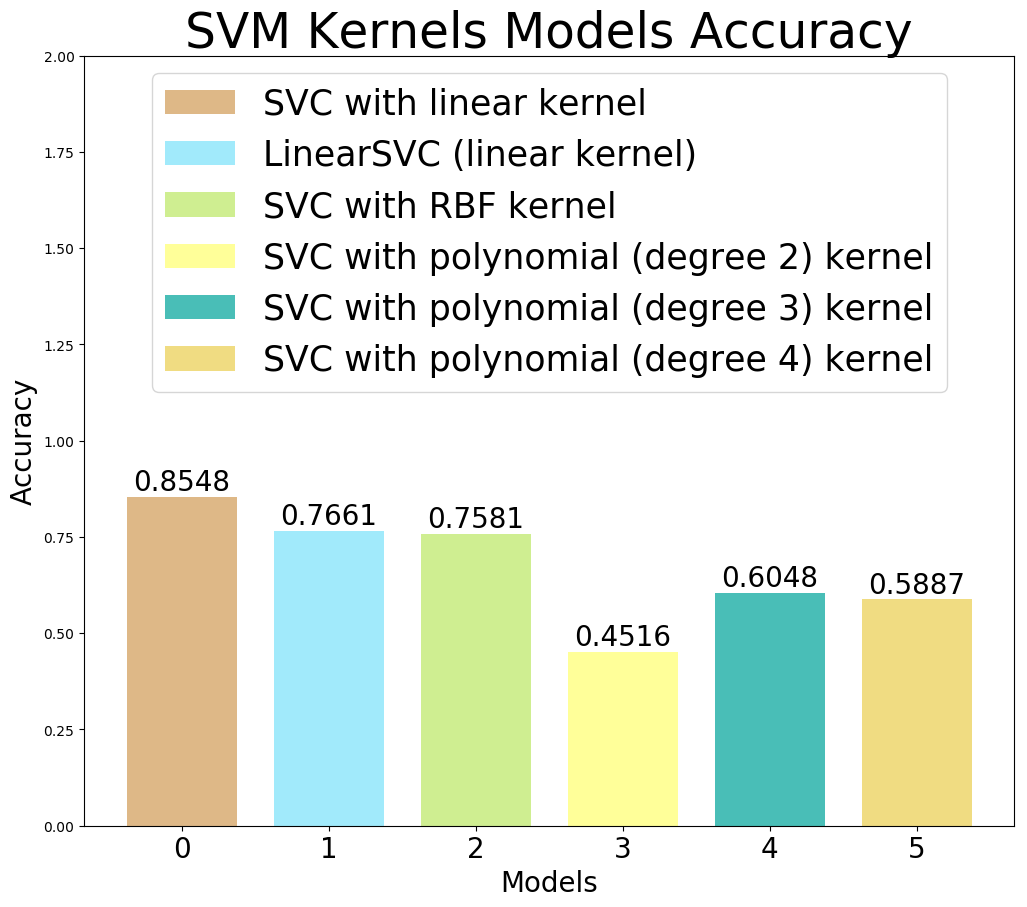

In [37]:
barchart(accuracy,titles,"")

# Ridge Classifier

In [38]:
'''RidgeClassifier'''
from sklearn.linear_model import RidgeClassifier

#table
tRC = Table(names=('id','alpha','normalize','class_weight','time','score'))

reg = [.001,.1,1,10]
cw = [None,'balanced']

for i in range(0,len(reg)):
    for k in range(0,len(cw)):
        #Model
        rc = RidgeClassifier(alpha=reg[i],
                            normalize = True,
                            class_weight = cw[k])
        #Fit
        startTime = time.time() #start time
        rc.fit(X_train,y_train)
        endTime = time.time() #end time
        elaspedTime = round(endTime-startTime,4)

        #Add to row
        #tRC.add_row([i+1+(k/10),reg[i],1,1,elaspedTime,round(rc.score(testx,testy),4)])
        tRC.add_row([2*i+k,1,1,1,1,1])
        tRC[2*i+k]=[2*i+k,reg[i],1,1,elaspedTime,round(rc.score(X_test,y_test),4)]
        tRC['normalize'] = ['True']
        
tRC['class_weight'] = [cw[0],cw[1],cw[0],cw[1],cw[0],cw[1],cw[0],cw[1]]
print("RC")
tRC.pprint(max_width=-1)

RC
 id alpha normalize class_weight  time score 
--- ----- --------- ------------ ----- ------
0.0 0.001      True         None 0.004 0.6452
1.0 0.001      True     balanced 0.002 0.7258
2.0   0.1      True         None 0.001 0.5887
3.0   0.1      True     balanced 0.002 0.7016
4.0   1.0      True         None 0.001 0.4677
5.0   1.0      True     balanced 0.002 0.5242
6.0  10.0      True         None 0.002 0.4516
7.0  10.0      True     balanced 0.002 0.5161


# SGD Classifier

In [39]:
'''SGD Classifier'''
from sklearn.linear_model import SGDClassifier

#table
tlmP = Table(names=('id','Penalty','Alpha','time','score'))

l = ['hinge','log','modified_huber','squared_hinge','perceptron']
p = ['l2','l1','elasticnet']
reg = [.0001,.1,1,10]

for i in range(0,len(p)):
    for k in range(0,len(reg)):
        #Model
        sgd= SGDClassifier(penalty=p[i],alpha=reg[k])
        #Fit
        startTime = time.time() #start time
        sgd.fit(X_train,y_train)
        endTime = time.time() #end time
        elaspedTime = round(endTime-startTime,4)

        #Add to row
        tlmP.add_row([i+1+(k/10),i+1,reg[k],elaspedTime,round(sgd.score(X_test,y_test),4)])

print("SGD")
tlmP.pprint(max_width=-1)

SGD
 id Penalty Alpha   time score 
--- ------- ------ ----- ------
1.0     1.0 0.0001 0.003 0.4677
1.1     1.0    0.1 0.002 0.3629
1.2     1.0    1.0 0.002 0.5645
1.3     1.0   10.0 0.002 0.5806
2.0     2.0 0.0001 0.002 0.6129
2.1     2.0    0.1 0.002 0.2742
2.2     2.0    1.0 0.001 0.3387
2.3     2.0   10.0 0.002 0.2903
3.0     3.0 0.0001 0.002 0.6613
3.1     3.0    0.1 0.005 0.6048
3.2     3.0    1.0 0.002 0.3387
3.3     3.0   10.0 0.002 0.5081


C:\Users\migue\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


# Decision Trees

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

#Information gain functions and tree depth
criterions = ['gini','entropy']
depths = [2,3,4,5,7,10]

#Store accuracy of the trees
AccuracyTree = np.zeros((len(depths),2,2))

for i,criter in enumerate(criterions):
    print("\nAccuracy for ",criter, " models.")
    for j, depth in enumerate(depths):
        print("Depth ", depth, ":")
        tree = DecisionTreeClassifier(criterion=criter, max_depth=depth, random_state=0)
        tree.fit(X_train, y_train)
        AccuracyTree[j,0,i] = tree.score(X_train,y_train)
        print('Training: ',AccuracyTree[j,0,i])
        AccuracyTree[j,1,i] = tree.score(X_test,y_test)
        print('Testing: ',AccuracyTree[j,1,i])
        



Accuracy for  gini  models.
Depth  2 :
Training:  0.57785467128
Testing:  0.629032258065
Depth  3 :
Training:  0.650519031142
Testing:  0.637096774194
Depth  4 :
Training:  0.733564013841
Testing:  0.66935483871
Depth  5 :
Training:  0.820069204152
Testing:  0.717741935484
Depth  7 :
Training:  0.930795847751
Testing:  0.758064516129
Depth  10 :
Training:  1.0
Testing:  0.75

Accuracy for  entropy  models.
Depth  2 :
Training:  0.598615916955
Testing:  0.620967741935
Depth  3 :
Training:  0.674740484429
Testing:  0.645161290323
Depth  4 :
Training:  0.726643598616
Testing:  0.693548387097
Depth  5 :
Training:  0.83044982699
Testing:  0.733870967742
Depth  7 :
Training:  0.968858131488
Testing:  0.741935483871
Depth  10 :
Training:  1.0
Testing:  0.766129032258


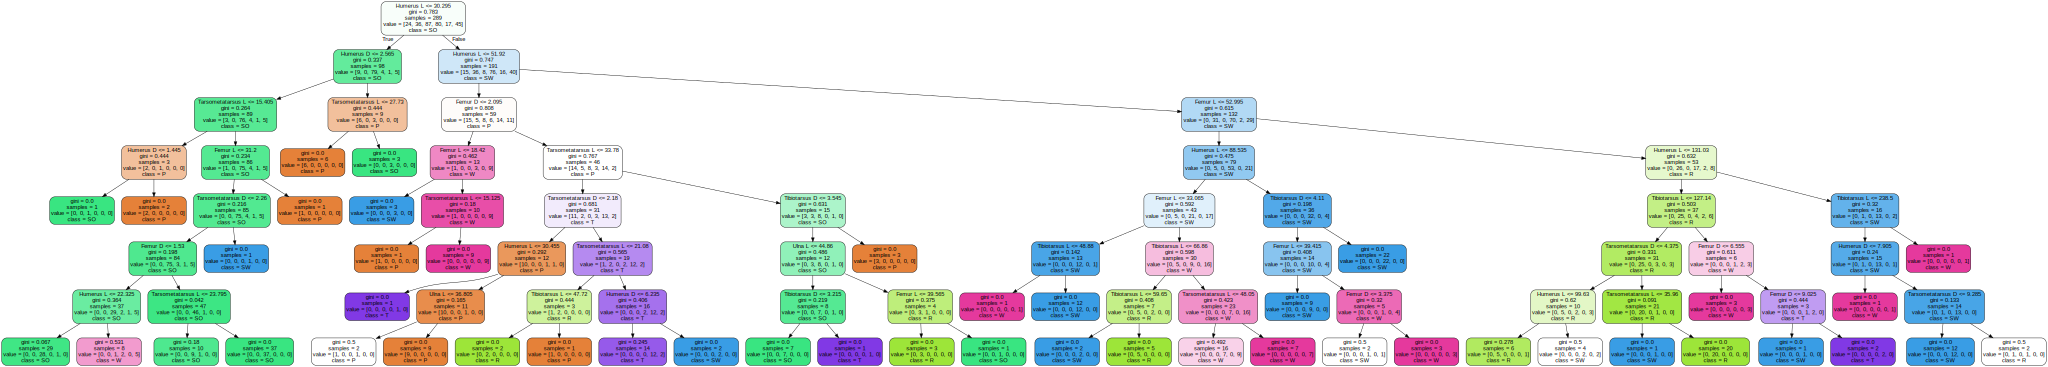

In [41]:
#Plot best decision tree for Gini
tree = DecisionTreeClassifier(criterion='gini', max_depth=7, random_state=0)
tree.fit(X_train, y_train)
    
export_graphviz(tree, out_file='T25.dot',filled= True, class_names=list(label_dict.values()),  rounded=True, 
                feature_names= [ 'Humerus L', 'Humerus D', 'Ulna L','Ulna D', 'Femur L', 'Femur D',
              'Tibiotarsus L', 'Tibiotarsus D', 'Tarsometatarsus L','Tarsometatarsus D'])
with open('T25.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

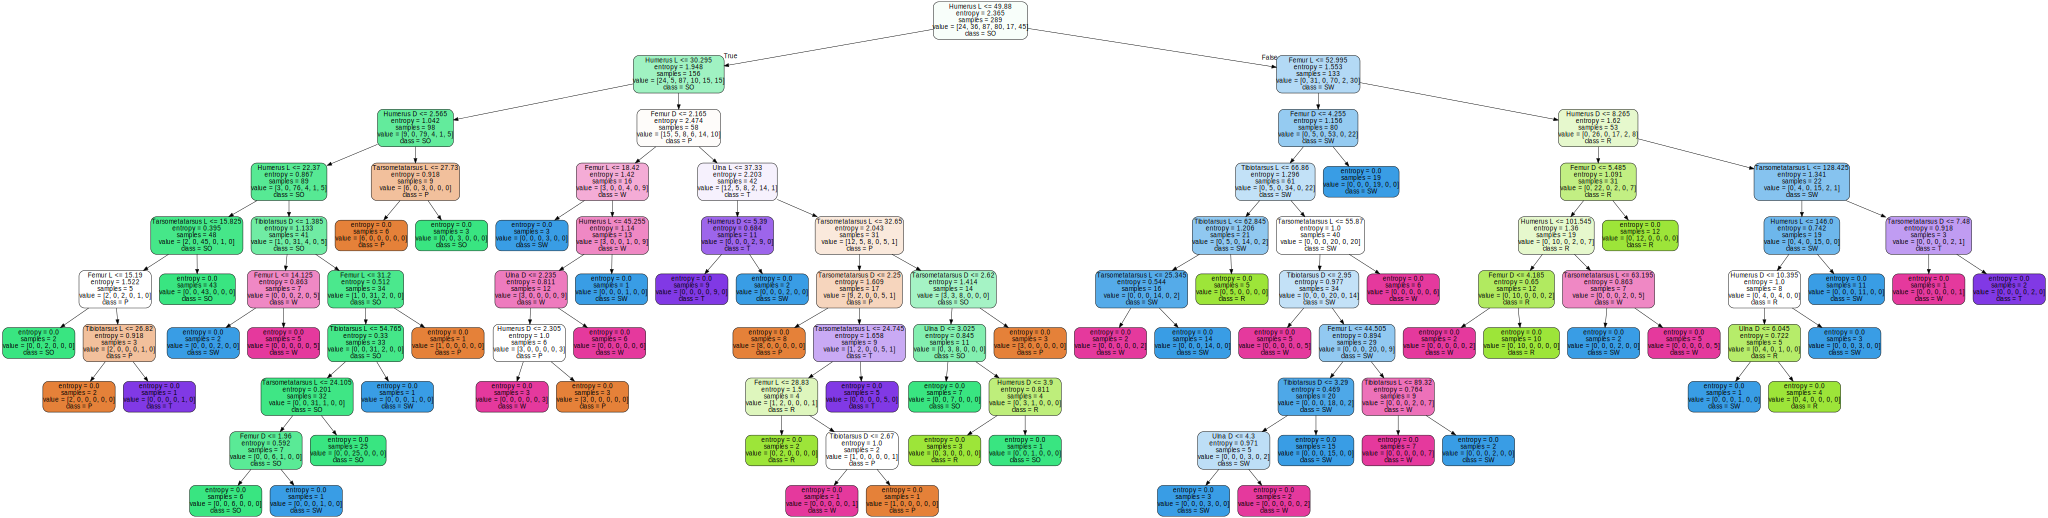

In [42]:
#Plot best decision tree for Gini
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10, random_state=0)
tree.fit(X_train, y_train)
    
export_graphviz(tree, out_file='T25.dot',filled= True, class_names=list(label_dict.values()),  rounded=True, 
                feature_names= [ 'Humerus L', 'Humerus D', 'Ulna L','Ulna D', 'Femur L', 'Femur D',
              'Tibiotarsus L', 'Tibiotarsus D', 'Tarsometatarsus L','Tarsometatarsus D'])
with open('T25.dot') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

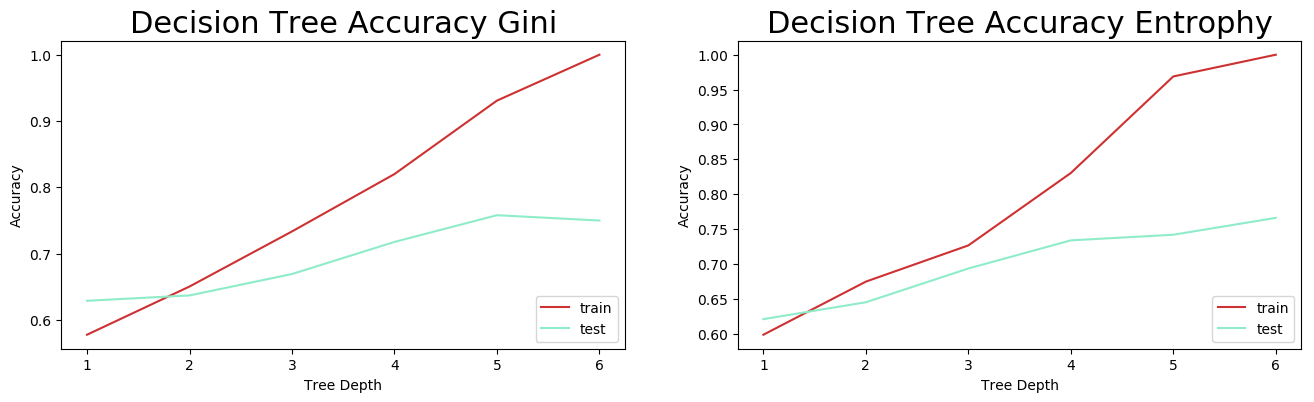

In [43]:
#Accuracy Graph
plt.close('all')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (16,4))
for i,accu, til in zip([0,1],[AccuracyTree[:,:,0],AccuracyTree[:,:,1]],['Decision Tree Accuracy Gini','Decision Tree Accuracy Entrophy']):
    ax[i].set_xlabel('Tree Depth')
    ax[i].set_ylabel('Accuracy')
    ax[i].set_title(til, fontsize =22)
    ax[i].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].plot(np.arange(1,7),accu[:,0], label='train', color='#CD3131')
    ax[i].plot(np.arange(1,7),accu[:,1], label='test', color='#8FECC8')
    ax[i].legend(loc='lower right', fontsize='medium')
plt.show()

# Gradient Boosting

In [44]:
'''GradientBoostingClassifier'''
from sklearn.ensemble import GradientBoostingClassifier

#table
tGBC = Table(names=('id','eta','max_depth','n_estimators','time','score'))

lrate = [.001,.01,1]
depth = [3,9]
num = [100,1000]

for i in range(0,len(lrate)):
    for j in range(0,len(depth)):
        for k in range(0,len(num)):
            #Model
            gbc= GradientBoostingClassifier(loss='deviance', 
                                            n_estimators=num[k],
                                            max_depth=depth[j], 
                                            learning_rate=lrate[i])
             #Fit
            startTime = time.time() #start time
            gbc.fit(X_train,y_train)
            endTime = time.time() #end time
            elaspedTime = round(endTime-startTime,4)

            #Add to row
            tGBC.add_row([i+1+(j/10)+(k/100),lrate[i],depth[j],num[k],elaspedTime,round(gbc.score(X_test,y_test),4)])

print("GBC")
tGBC.pprint(max_width=-1)

GBC
 id   eta  max_depth n_estimators   time  score 
---- ----- --------- ------------ ------- ------
 1.0 0.001       3.0        100.0  0.4047 0.6774
1.01 0.001       3.0       1000.0  4.2444 0.7742
 1.1 0.001       9.0        100.0   0.884 0.6774
1.11 0.001       9.0       1000.0 12.0375 0.7339
 2.0  0.01       3.0        100.0  0.3656 0.7742
2.01  0.01       3.0       1000.0  3.5453 0.7823
 2.1  0.01       9.0        100.0  1.2089 0.7339
2.11  0.01       9.0       1000.0  4.7549   0.75
 3.0   1.0       3.0        100.0  0.1915 0.7823
3.01   1.0       3.0       1000.0  1.5952 0.7823
 3.1   1.0       9.0        100.0   0.191 0.8065
3.11   1.0       9.0       1000.0  1.5936 0.8065


# AdaBoost

In [45]:
'''AdaBoost'''
from sklearn.ensemble import AdaBoostClassifier
#table
tABC = Table(names=('id','eta','n_estimators','time','score'))

lrate = [.0001,.001,.01,]
num = [50,100,1000]

for i in range(0,len(lrate)):
    for k in range(0,len(num)):
        #Model
        abc= AdaBoostClassifier(n_estimators=num[k],
                                learning_rate=lrate[i])
        #Fit
        startTime = time.time() #start time
        abc.fit(X_train,y_train)
        endTime = time.time() #end time
        elaspedTime = round(endTime-startTime,4)

        #Add to row
        tABC.add_row([i+1+(j/10)+(k/100),lrate[i],num[k],elaspedTime,round(abc.score(X_test,y_test),4)])

print("AdaBoost")
tABC.pprint(max_width=-1)

AdaBoost
 id   eta   n_estimators  time  score 
---- ------ ------------ ------ ------
 1.1 0.0001         50.0 0.0948 0.5565
1.11 0.0001        100.0 0.1367 0.5565
1.12 0.0001       1000.0 1.2019 0.5565
 2.1  0.001         50.0 0.0534 0.5565
2.11  0.001        100.0 0.1206 0.5565
2.12  0.001       1000.0 1.2388 0.6129
 3.1   0.01         50.0 0.0597 0.5806
3.11   0.01        100.0 0.1193 0.6129
3.12   0.01       1000.0 1.1886 0.2258


# Random Forests

In [46]:
from sklearn.ensemble import RandomForestClassifier

t = Table(names=('id','criterion','size','time','score'))
t2 = Table(names=('id','size','time','score'))

'''Random Forests'''

#REDO THIS WITH 
#n_estimators 10, 50, 100 200
#criterion gini, entropy
#max depth : 10, 15, 20
#class weight none, balanced
#n_estimators
forestSize = [100,200,300,400,500,600,700,800,900,1000]
c = ['gini','entropy']
#hold scores
scoresRF = np.zeros(len(forestSize))
scoresRFoob = np.zeros(len(forestSize))



for i in range(0,len(forestSize)):
    for j in range(0, len(c)):
        '''RandomForest'''
        rfc = RandomForestClassifier(criterion=c[j],
                                     n_estimators=forestSize[i],
                                    bootstrap=True)
        #Fit
        startTime = time.time() #start time
        rfc.fit(X_train,y_train)
        endTime = time.time() #end time
        elaspedTime = round(endTime-startTime,4)

        #add to scores
        scoresRF[i] = round(rfc.score(X_test,y_test),4)

        #Add to row
        t.add_row([2*i+1+j,1,forestSize[i],elaspedTime,round(rfc.score(X_test,y_test),4)])
    """ '''RandomForest w OOB'''
        rfc = RandomForestClassifier(criterion=c[j],
                                    n_estimators=forestSize[i],
                                    oob_score=True)
        #Fit
        startTime = time.time() #start time
        rfc.fit(X,y)
        endTime=time.time()
        elaspedTime=round(endTime-startTime,4)

        #add to scores
        scoresRFoob[i] = round(rfc.oob_score_,4)

        #Add to row
        t2.add_row([i+1,forestSize[i],elaspedTime,round(rfc.oob_score_,4)])
    """
t['criterion']=[c[0],c[1],c[0],c[1],c[0],c[1],c[0],c[1],c[0],c[1],c[0],c[1],c[0],c[1],c[0],c[1],c[0],c[1],c[0],c[1]]

        
# oob do not need independent validation set

#print Table
print("RandomForest")
t.pprint(max_width=-1)
print(max(scoresRF))
'''
print("RandomForest w/ OOB")
t2.pprint(max_width=-1)
print(max(scoresRFoob))
'''

RandomForest
 id  criterion  size   time  score 
---- --------- ------ ------ ------
 1.0      gini  100.0  0.136 0.8468
 2.0   entropy  100.0 0.1451 0.8468
 3.0      gini  200.0   0.24 0.8468
 4.0   entropy  200.0 0.2999 0.7984
 5.0      gini  300.0 0.3382 0.8306
 6.0   entropy  300.0  0.448 0.8306
 7.0      gini  400.0 0.4623 0.8548
 8.0   entropy  400.0  0.601 0.8145
 9.0      gini  500.0 0.5761 0.8548
10.0   entropy  500.0 0.7392 0.8306
11.0      gini  600.0 0.7073 0.8387
12.0   entropy  600.0   0.89 0.8387
13.0      gini  700.0 0.8082 0.8306
14.0   entropy  700.0 1.0489 0.8145
15.0      gini  800.0 0.9318 0.8387
16.0   entropy  800.0 1.2838 0.8226
17.0      gini  900.0 1.0802 0.8387
18.0   entropy  900.0  1.372 0.8306
19.0      gini 1000.0 1.1958 0.8468
20.0   entropy 1000.0 1.4924 0.8226
0.8468


'\nprint("RandomForest w/ OOB")\nt2.pprint(max_width=-1)\nprint(max(scoresRFoob))\n'

# K-nearest Neighbors

In [47]:
from sklearn.neighbors import KNeighborsClassifier as Knn
h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(colorsBirds)
cmap_bold = ListedColormap(colorsBirds)
neighbors = [2,5,10,25,50,100,200]
weights = ['uniform', 'distance']
timeUniform = []
timeDistance = []
AccuUni = []
AccuDis = []
for weight in weights:
    for neighbor_N in neighbors:
        knn_model = Knn(neighbor_N, weights=weight)
        #knn_model = Knn(neighbor_N)
        t0=time.time()
        knn_model.fit(X_train_std, y_train_std)
        #print(knn_model.score(X_test,y_test))
        if weight == 'uniform':
            AccuUni.append(np.around(knn_model.score(X_test_std,y_test_std),decimals=4))
            timeUniform.append(np.around(time.time()-t0, decimals = 8))
        else:
            AccuDis.append(np.around(knn_model.score(X_test_std,y_test_std), decimals=4))
            timeDistance.append(np.around(time.time()-t0,decimals = 8))

tableUniform = Table([neighbors, timeUniform, AccuUni], names =('Number of Neighbors','Time','Test Accuracy'))
tableDistance = Table([neighbors, timeDistance, AccuDis], names =('Number of Neighbors','Time','Test Accuracy'))

In [48]:
tableUniform

<Table length=7>
Number of Neighbors    Time    Test Accuracy
       int32         float64      float64   
------------------- ---------- -------------
                  2 0.00300741        0.7581
                  5 0.00200462        0.7258
                 10 0.00200534        0.6935
                 25 0.00200534        0.6129
                 50 0.00150347        0.5968
                100 0.00401235        0.5323
                200 0.00401044        0.4516

In [49]:
tableDistance

<Table length=7>
Number of Neighbors    Time    Test Accuracy
       int32         float64      float64   
------------------- ---------- -------------
                  2 0.00200558        0.8306
                  5 0.00200558        0.7661
                 10  0.0020051        0.7419
                 25 0.00300837        0.6855
                 50 0.00300765        0.6613
                100 0.00501323        0.5806
                200 0.00501347        0.5161

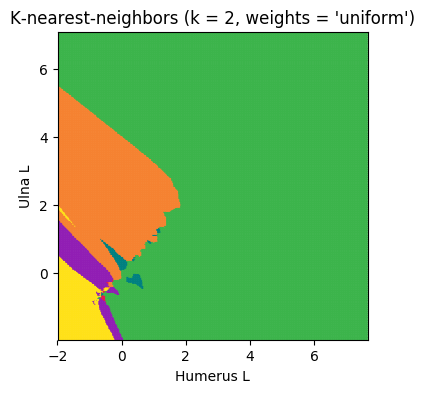

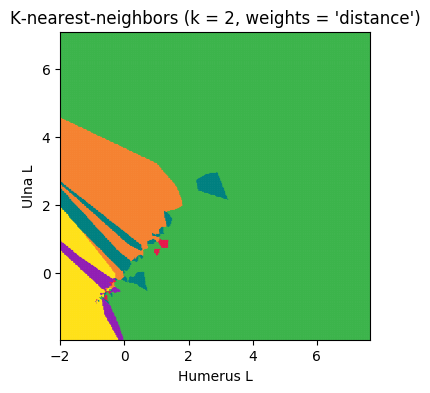

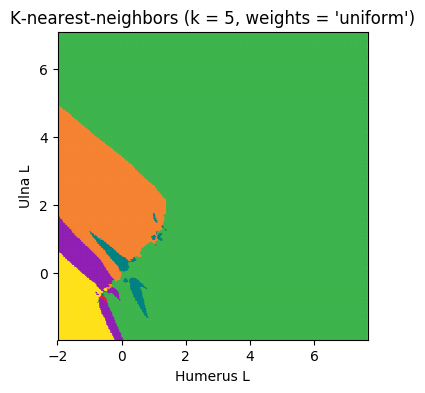

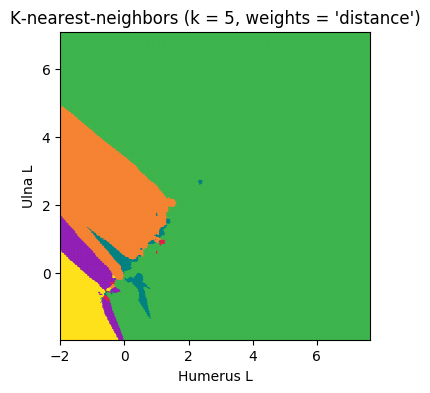

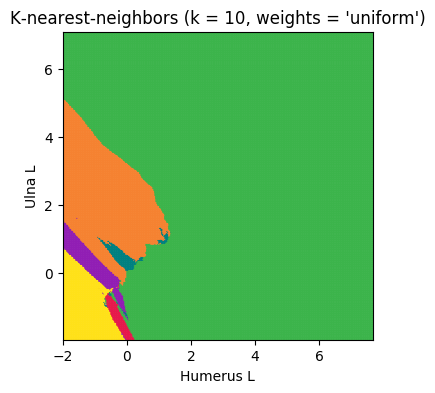

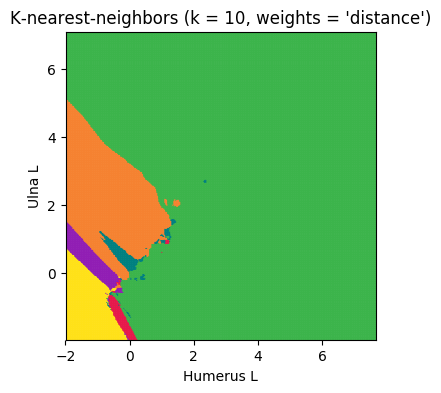

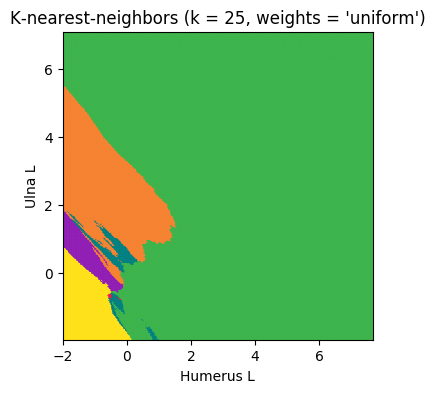

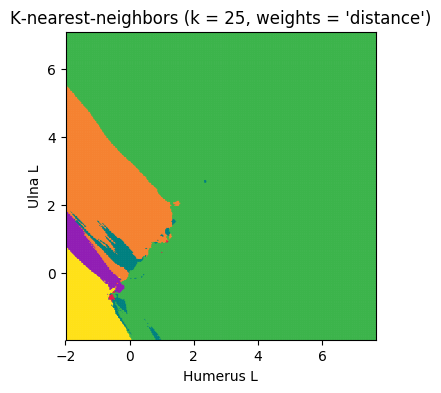

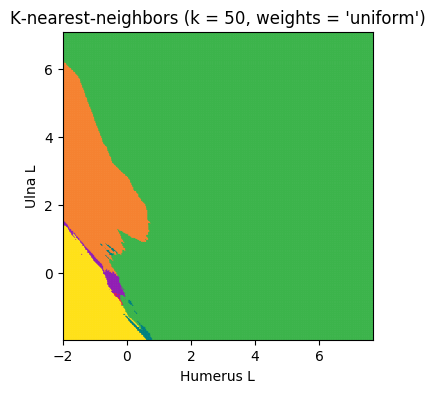

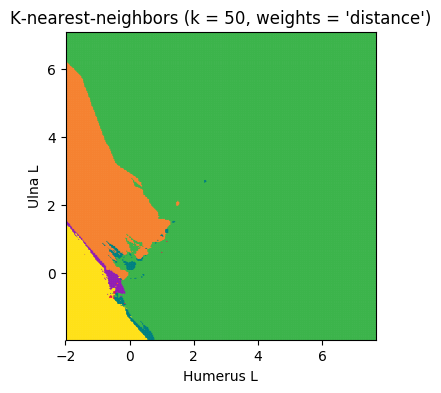

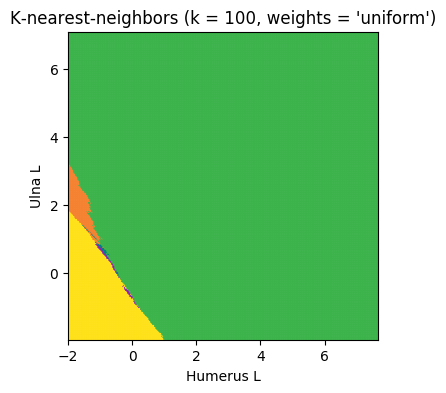

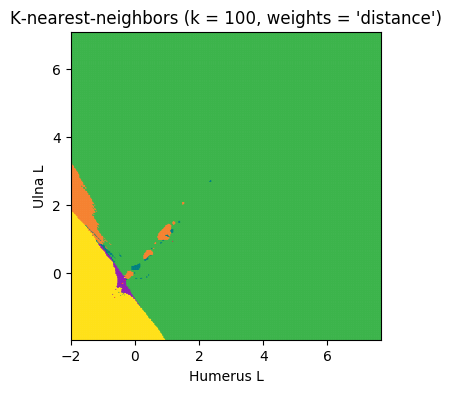

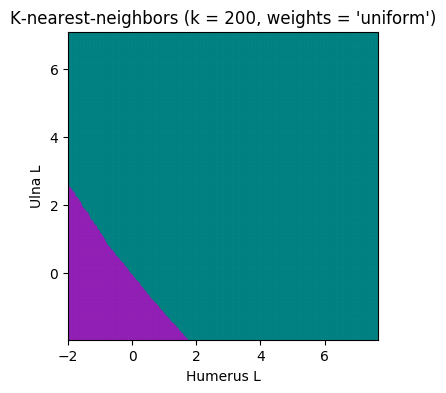

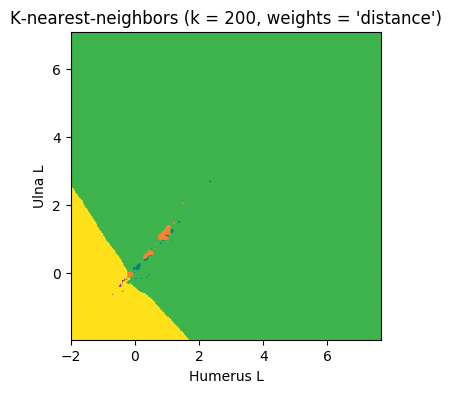

In [50]:
for neighbor_N in neighbors:
    for weights in ['uniform', 'distance']:
    
        # we create an instance of Neighbours Classifier and fit the data.
        knn_model = Knn(neighbor_N, weights=weights)
        knn_model.fit(X_train_std[:,(0,2)], y_train) #pick feature 0 and 2 which correlate the most

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        x_min, x_max = X_train_std[:, 0].min() - 1, X_train_std[:, 0].max() + 1
        y_min, y_max = X_train_std[:, 2].min() - 1, X_train_std[:, 2].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
        Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.figure(figsize=(4,4))
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light,alpha=0.6)

        # Plot also the training points
        plt.scatter(X_train[:, 0], X_train[:, 2], c=y_train, cmap=cmap_bold,
                edgecolor='k', s=20, alpha=0.9)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("K-nearest-neighbors (k = %i, weights = '%s')"% (neighbor_N, weights))
        plt.xlabel(label[0]) #Put labels
        plt.ylabel(label[2])

plt.show()

# K-means 

In [51]:
from sklearn.cluster import KMeans as km
from sklearn.metrics import accuracy_score
clusters = [3,4,6,8,10,15]
for clu in clusters:
        km_model = km(clu)
        t0=time.time()
        km_model.fit(X_train, y_train)
        y_test_pred= km_model.predict(X_test)
        print('Clusters ',clu,' Accuracy: ',accuracy_score(y_test, y_test_pred))

Clusters  3  Accuracy:  0.354838709677
Clusters  4  Accuracy:  0.0645161290323
Clusters  6  Accuracy:  0.209677419355
Clusters  8  Accuracy:  0.201612903226
Clusters  10  Accuracy:  0.16935483871
Clusters  15  Accuracy:  0.0483870967742


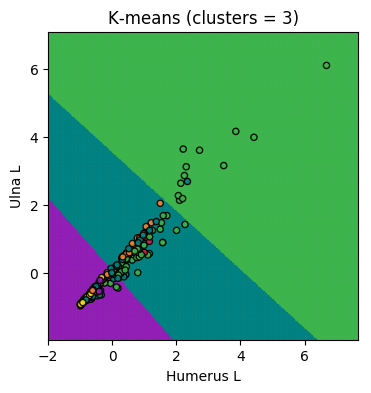

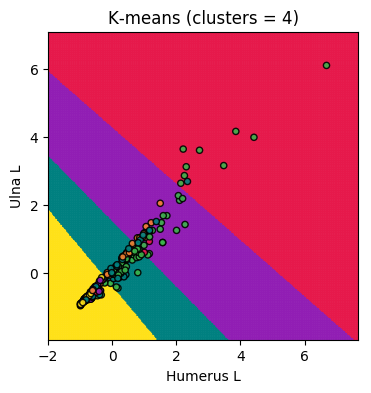

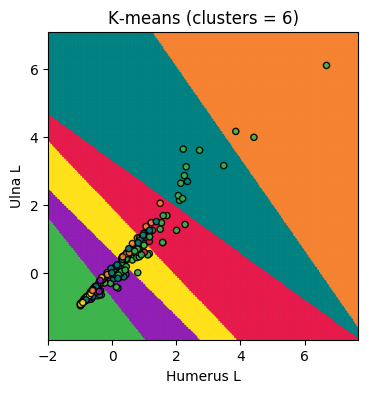

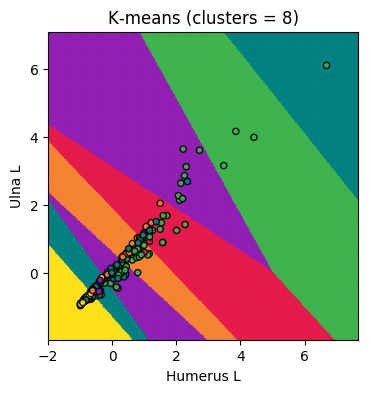

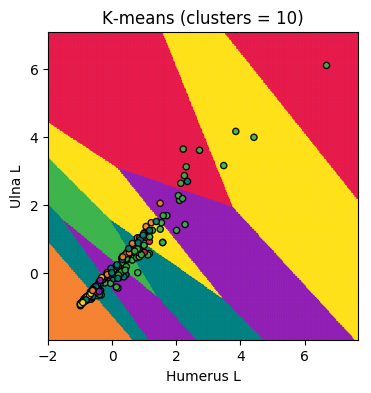

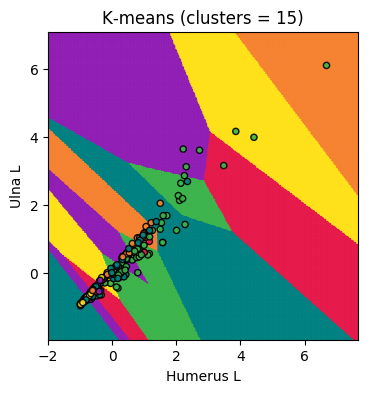

In [52]:
#Miguel
from sklearn.cluster import KMeans as km

for clu in clusters:
    # we create an instance of  Kmeans and fit the data.
    knn_model = km(n_clusters=clu)
    knn_model.fit(X_train_std[:,(0,2)], y_train_std) #pick feature 0 and 2 which correlate the most

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_train_std[:, 0].min() - 1, X_train_std[:, 0].max() + 1
    y_min, y_max = X_train_std[:, 2].min() - 1, X_train_std[:, 2].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(4,4))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light,alpha=0.6)

    # Plot also the training points
    plt.scatter(X_train_std[:, 0], X_train_std[:, 2], c=y_train, cmap=cmap_bold,
                edgecolor='k', s=20, alpha=0.9)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("K-means (clusters = %i)"% (clu))
    plt.xlabel(label[0]) #Put labels
    plt.ylabel(label[2])

plt.show()


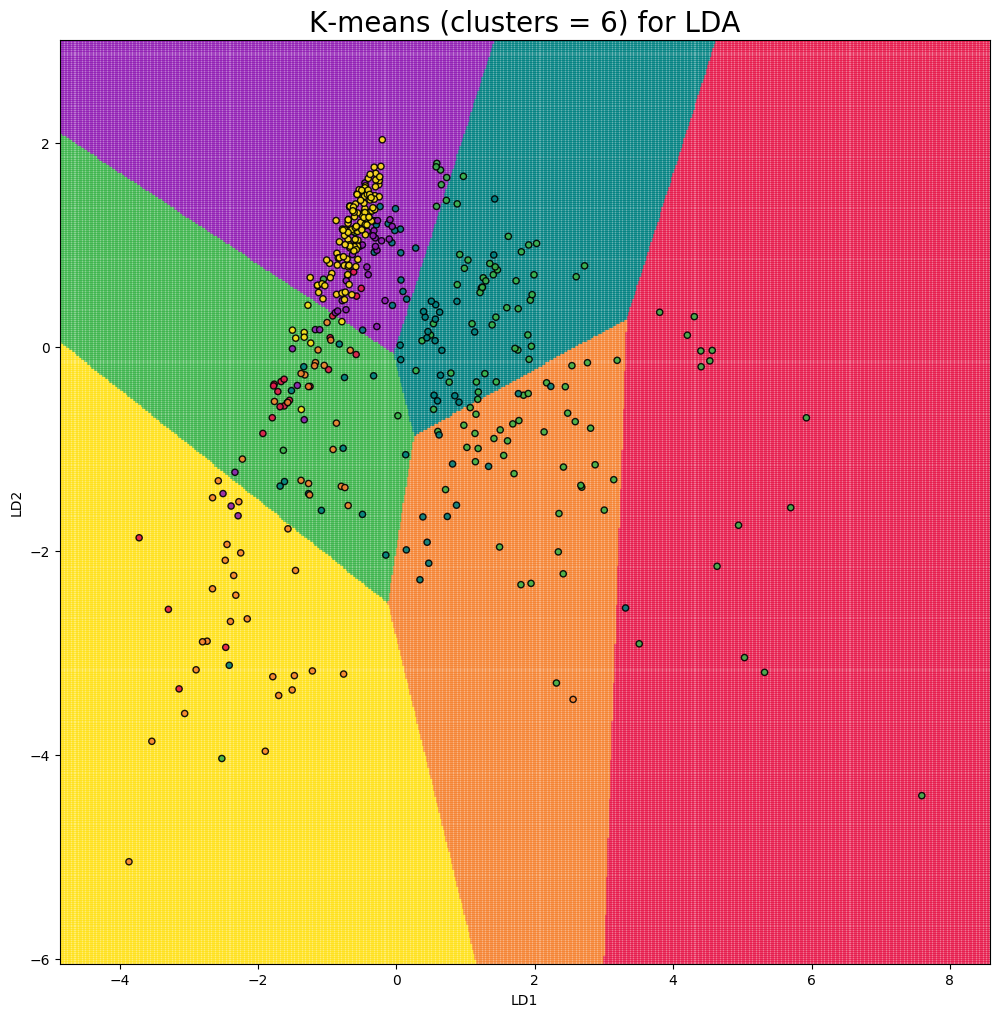

In [53]:
clusters = [6]
for clu in clusters:
    # we create an instance of Kmeans and fit the data.
    knn_model = km(n_clusters=clu)
    knn_model.fit(Xlda,y) #pass LDA subspace
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = Xlda[:, 0].min() - 1, Xlda[:, 0].max() + 1
    y_min, y_max = Xlda[:, 1].min() - 1, Xlda[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn_model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(12,12))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light,alpha=0.6)

    # Plot also the training points
    plt.scatter(Xlda[:, 0], Xlda[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20, alpha=0.9)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("K-means (clusters = %i) for LDA"% (clu),fontsize=20)

    plt.xlabel('LD1') #Put labels
    plt.ylabel('LD2')

plt.show()

# Naive Bayes

In [54]:
'''Naive Bayes'''
from sklearn.naive_bayes import GaussianNB

#table
tNB = Table(names=('id','time','score'))


for i in range(0,2):
    #Model
    gnb = GaussianNB()

    #Fit
    startTime = time.time() #start time
    gnb.fit(X_train,y_train)
    endTime = time.time() #end time
    elaspedTime = round(endTime-startTime,4)

    #Add to row
    tNB.add_row([i+1,elaspedTime,round(gnb.score(X_test,y_test),4)])
    
print("NaiveBayes")
tNB.pprint(max_width=-1)

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
scaler = StandardScaler()
scaler.fit(X_train)
trainxs = scaler.transform(X_train)
testxs = scaler.transform(X_test)
print(confusion_matrix(y_test,gnb.predict(X_test)))
print(classification_report(y_test,gnb.predict(X_test)))

NaiveBayes
 id time score 
--- ---- ------
1.0  0.0 0.5161
2.0  0.0 0.5161
[[ 6  0  7  0  0  1]
 [ 4  6  0  2  0  0]
 [ 1  0 36  0  0  0]
 [ 2  2  4 12  0 16]
 [ 4  2  0  0  0  0]
 [ 4  4  4  3  0  4]]
             precision    recall  f1-score   support

          0       0.29      0.43      0.34        14
          1       0.43      0.50      0.46        12
          2       0.71      0.97      0.82        37
          3       0.71      0.33      0.45        36
          4       0.00      0.00      0.00         6
          5       0.19      0.21      0.20        19

avg / total       0.52      0.52      0.49       124



C:\Users\migue\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Regression 

Accuracy for  Linear Regression :  0.9566
Accuracy for  Ridge :  0.9566
Accuracy for  Kernel Ridge :  0.9566
Accuracy for  Elastic Net :  0.5196


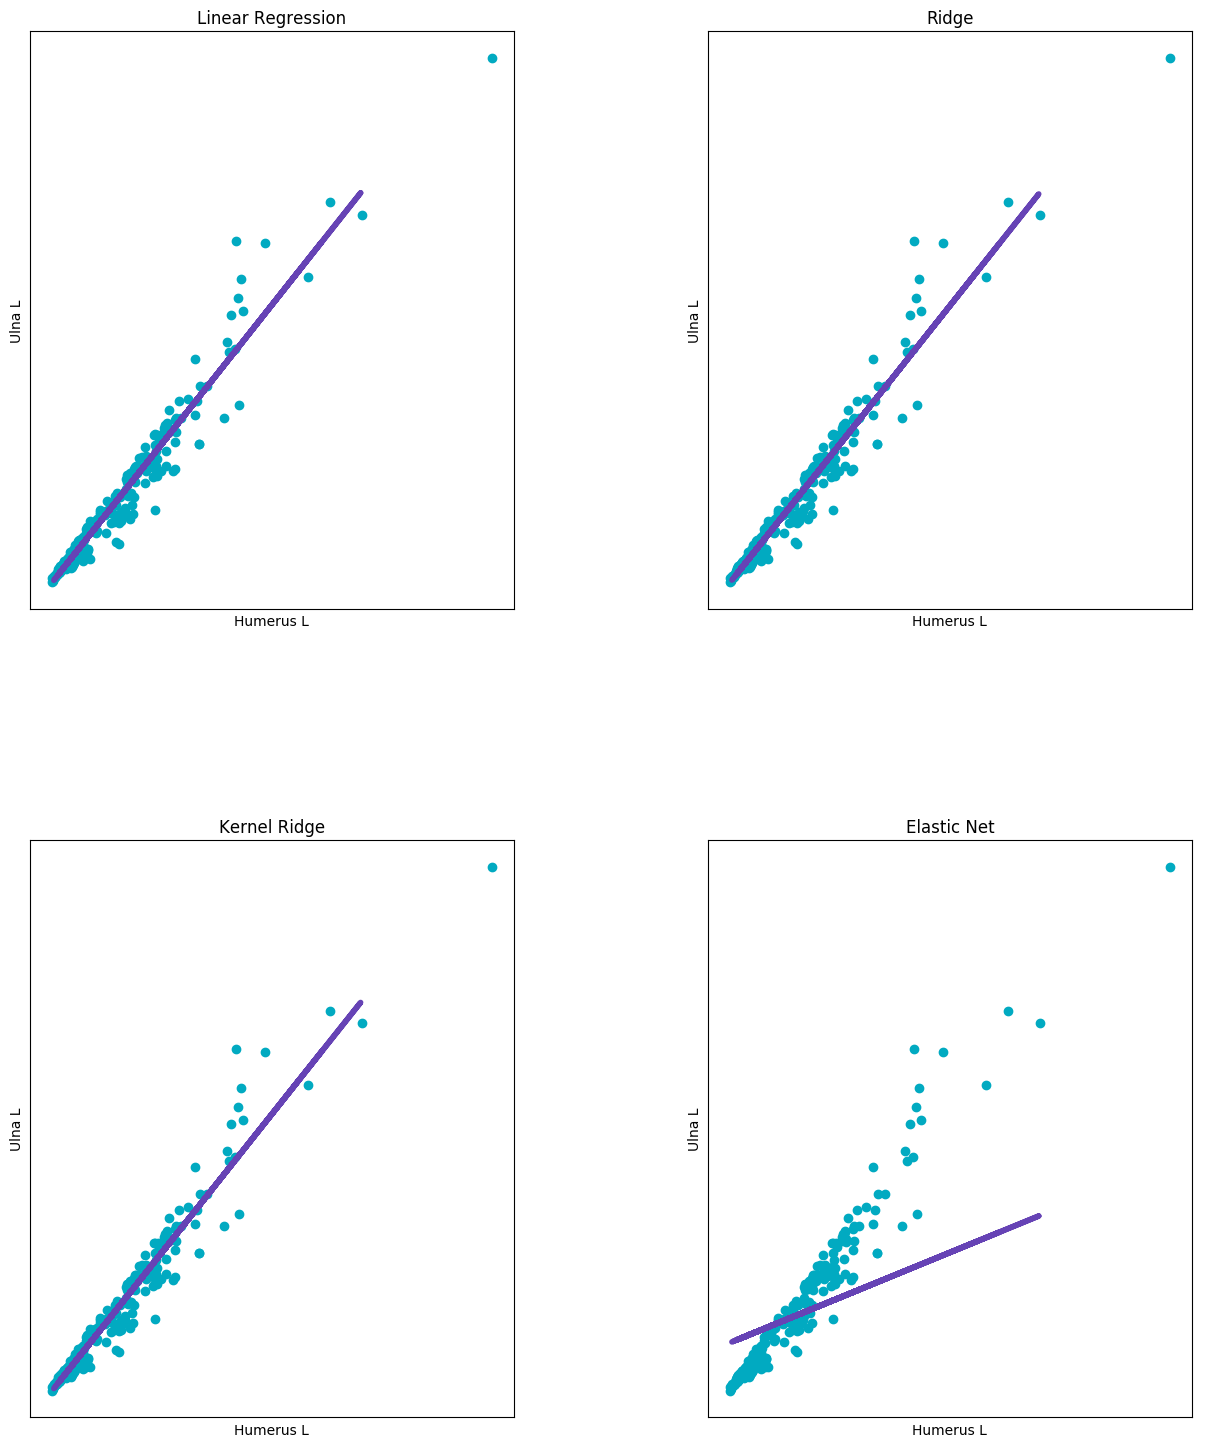

In [55]:
from sklearn import linear_model, svm, kernel_ridge
# reshape data
X_1 = X_train_std[:,(0)].reshape(-1,1)
X_2 = X_train_std[:,(2)].reshape(-1,1)
X_1t = X_test_std[:,(0)].reshape(-1,1)
X_2t = X_test_std[:,(2)].reshape(-1,1)
#Intances of models
models = (linear_model.LinearRegression(),
          linear_model.Ridge(),
          kernel_ridge.KernelRidge(),
          linear_model.ElasticNet()
          )

#Train models
models = (clf.fit(X_1,X_2) for clf in models)

titles = ('Linear Regression',
          'Ridge',
          'Kernel Ridge',
          'Elastic Net') 

# Set-up 2x2 grid for plotting.
fig, sub = plt.subplots(nrows=2, ncols=2, figsize= (15,18))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

accuracy_test = []


for regr, title, ax in zip(models, titles, sub.flatten()):
    accuracy_test.append(np.around(regr.score(X_1t,X_2t),decimals =4))
    print('Accuracy for ',title,': ',np.around(regr.score(X_1t,X_2t),decimals =4))
    
    #Predictions
    predicted = regr.predict(X_1t)

    ax.scatter(X_1,X_2, color="#01AAC1")
    ax.plot(X_1t,predicted, color='#6643B5', linewidth=4)
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[2])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
plt.show()

# Neural Networks

In [56]:
'''MLP Classifier'''
from sklearn.neural_network import MLPClassifier
#from sklearn.metrics import classification_report,confusion_matrix

#table
tmlp = Table(names=('id','activation','solver','alpha','eta','time','score'))

h = [30,30,30]
a = ['logistic','tanh','relu']
s = ['lbfgs','adam']
al = [.0001,.001,.01,.1,1]
le = ['constant','invscaling']

for i in range(0,len(a)):
    for j in range(0,len(s)):
        for k in range(0,len(al)):
            for l in range(0,len(le)):
            
                #Model
                mlp= MLPClassifier(activation = a[i],
                                   solver = s[j],
                                   alpha = al[k],
                                   learning_rate = le[l])
                #Fit
                startTime = time.time() #start time
                mlp.fit(X_train,y_train)
                endTime = time.time() #end time
                elaspedTime = round(endTime-startTime,4)

                #Add to row
                tmlp.add_row([2*i+j+1+k/10+l/100,1,2,al[k],4,elaspedTime,round(mlp.score(X_test,y_test),4)])

print("MLP")
tmlp.pprint(max_width=-1,max_lines=-1)

C:\Users\migue\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLP
 id  activation solver alpha  eta  time  score 
---- ---------- ------ ------ --- ------ ------
 1.0        1.0    2.0 0.0001 4.0   0.22 0.8306
1.01        1.0    2.0 0.0001 4.0 0.2056 0.7742
 1.1        1.0    2.0  0.001 4.0 0.2286 0.8306
1.11        1.0    2.0  0.001 4.0 0.1994 0.8226
 1.2        1.0    2.0   0.01 4.0 0.2005  0.879
1.21        1.0    2.0   0.01 4.0 0.2002 0.8468
 1.3        1.0    2.0    0.1 4.0 0.1995 0.8871
1.31        1.0    2.0    0.1 4.0 0.1895 0.8306
 1.4        1.0    2.0    1.0 4.0 0.1885  0.879
1.41        1.0    2.0    1.0 4.0 0.1815 0.8952
 2.0        1.0    2.0 0.0001 4.0 0.4242 0.8468
2.01        1.0    2.0 0.0001 4.0 0.3066 0.7984
 2.1        1.0    2.0  0.001 4.0 0.2647 0.7984
2.11        1.0    2.0  0.001 4.0 0.2295 0.8468
 2.2        1.0    2.0   0.01 4.0 0.2439 0.7903
2.21        1.0    2.0   0.01 4.0 0.2527 0.8306
 2.3        1.0    2.0    0.1 4.0 0.2482 0.8145
2.31        1.0    2.0    0.1 4.0 0.2253 0.8226
 2.4        1.0    2.0    1.0 4.0 0.

In [57]:
def draw_confusion_matrix(cm):
    """
    define a function to draw confusion matrix.
    """
    _, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    sns.heatmap(
        cm, 
        square=True, 
        xticklabels=["P", "R", "SO", "SW", "T", "W"], 
        annot=True, 
        annot_kws={"fontsize": 12}, 
        yticklabels=["P", "R", "SO", "SW", "T", "W"], 
        cbar=False, 
        cmap=sns.light_palette("#00304e", as_cmap=True),
        ax=ax
    )

    ax.set_xlabel("predicted ecological group", fontsize=12)
    ax.set_ylabel("real ecological group", fontsize=12)
    ax.set_title("Confusion Matrix", fontsize=12)

             precision    recall  f1-score   support

          0       1.00      0.14      0.25        14
          1       0.56      0.83      0.67        12
          2       0.90      0.97      0.94        37
          3       0.91      0.83      0.87        36
          4       0.40      1.00      0.57         6
          5       0.81      0.68      0.74        19

avg / total       0.84      0.78      0.77       124



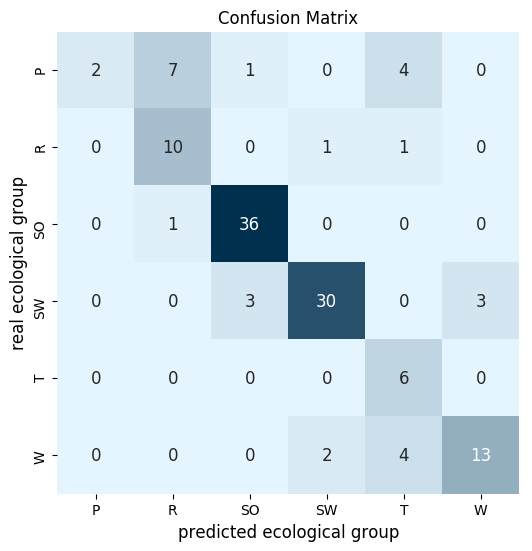

0.879


In [58]:
'''MLP Classifier SUMMARY END'''
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

#table
a = ['tanh']
s = ['lbfgs']
al = [1]
le = ['constant']

for i in range(0,len(a)):
    for j in range(0,len(s)):
        for k in range(0,len(al)):
            for l in range(0,len(le)):
            
                #Model
                mlpSum= MLPClassifier(activation = a[i],
                                   solver = s[j],
                                   alpha = al[k],
                                   learning_rate = le[l])
                #Fit
                startTime = time.time() #start time
                mlpSum.fit(X_train,y_train)
                endTime = time.time() #end time
                elaspedTime = round(endTime-startTime,4)
                
                predictions = mlp.predict(X_test)
                
                plt.close()
                draw_confusion_matrix(confusion_matrix(y_test,predictions))
                print(classification_report(y_test,predictions))
                
                plt.show()
                print(round(mlpSum.score(X_test,y_test),4))
                #Add to row
                #tmlp.add_row([2*i+j+1+k/10+l/100,1,2,al[k],4,elaspedTime,round(mlp.score(testx,testy),4)])